# Import dependencies

In [1]:
import numpy as np
import scipy
import matplotlib as mpl
from dolfinx import fem, mesh
from dataclasses import dataclass
from mpi4py import MPI
from src.solveStateEquation import getSourceTerm, solveStateEquation, buildControlFunction
from src.solveAdjointEquation import solveAdjointEquation
from src.visualization import plot_array, printIterationInfo, timeDependentVariableToGif
from src.ExtremalPoints import ExtremalPoint
from src.HesseMatrix import HesseMatrix
from src.osqp import computeOSQPStep
from src.iterationHelpers import pruneActiveSet, calculateDiscreteGradient, integrateVectorFunction, getIdxMax
from src.helpers import buildIterationFunction, computeObjective, linCombFunctionLists
from typing import List

@dataclass
class Parameters:
    T = 1
    dt = 0.01
    x1 = (0.5, 0.5)
    x2 = (-0.5, -0.5)
    area = 4
    d = 2
    mollify_const = 0.1
    newton_c = 100
    eta = 0.01
    alpha = 1e-6
    beta = 1e-4
    waveSpeed = 2
    randomFactor = 0.00
    maxIterations = 50
    pruneThreshold = 1e-7
    yd = []
    yd_adjoint = []
    standardInnerProducts = None
    msh = mesh.create_rectangle(
        comm=MPI.COMM_WORLD,
        points=((-1., -1.), (1.0, 1.0)),
        n=(32, 32),
        cell_type=mesh.CellType.triangle,
    )
    V = fem.functionspace(msh, ("Lagrange", 1))
    
params = Parameters()

# Setup problem

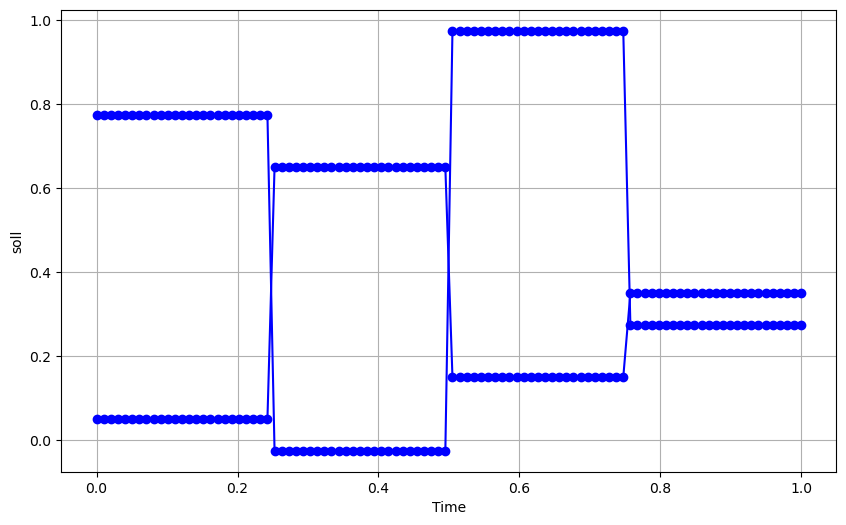

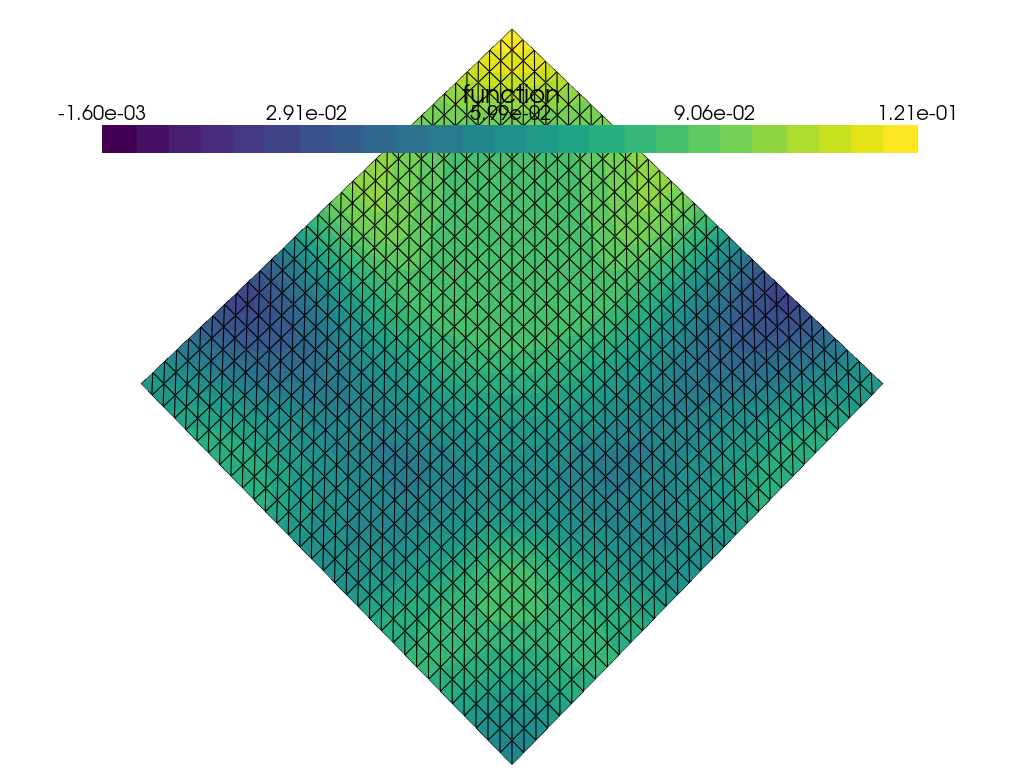

In [3]:
s1 = lambda t : 0.05 if t <= 0.25 else (0.65 if t <= 0.5 else (0.15 if t <= 0.75 else 0.35)) #/ params.alpha
s2 = lambda t : 0.775 if t <= 0.25 else (-0.025 if t <= 0.5 else (0.975 if t <= 0.75 else 0.275)) #/ params.alpha
g1 = getSourceTerm(params.x1, params)
g2 = getSourceTerm(params.x2, params)
control = buildControlFunction([g1, g2], [s1, s2], params)
K_u = solveStateEquation(control, params)
grid_size = K_u[0].x.array.shape
raw_matrices = [K_u_t.x.array for K_u_t in K_u]
norms = [np.linalg.norm(matrix, ord=2) for matrix in raw_matrices]
scale = params.randomFactor * np.mean(norms) / grid_size[0] * params.area
np.random.seed(42)
yd = [fem.Function(params.V) for _ in K_u]
for idx in range(len(yd)):
    yd[idx].x.array[:] = K_u[idx].x.array + 0*np.random.normal(loc=0.0, scale=scale, size=grid_size)
params.yd = yd
params.yd_adjoint = solveAdjointEquation(params.yd, params)
discretInterval = np.linspace(0, params.T, int(params.T/params.dt))
array = np.ndarray((int(params.T/params.dt), 2))
array[:, 0] = np.array([s1(t) for t in discretInterval])
array[:, 1] = np.array([s2(t) for t in discretInterval])
plot_array(array, params.T, label='soll')
timeDependentVariableToGif(yd, 'output/observation.gif')

# Minimization algorithm

Objective upper bound:  0.01130747762242352
weights:  [] slope:  [ 0.43415971 -0.28884368] y_shift [0.15707222 0.60133205]
Objective:  0.0001914484769896025
0 : Active set:
slope:  [ 0.43415971 -0.28884368] y_shift [0.15707222 0.60133205]
0 : Hesse condition: 178.96107856891285


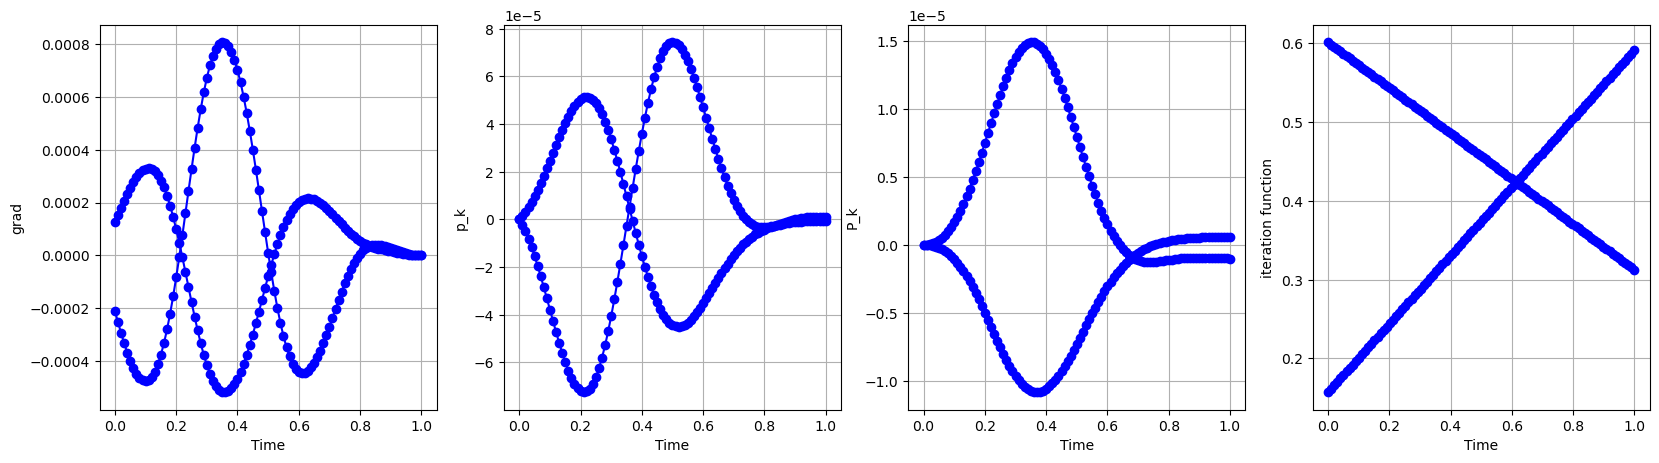

|p_max|/alpha:  88.89780795092977 , |P_max|/beta:  0.18409524096660704
x_S:  0.21 x_K:  0.36 
New point: sigma= [ 0.57695517 -0.81677582] x_0 = 0.21 , type = 0
weights:  [1.30287753e-06] slope:  [-0.83679813  1.52403038] y_shift [0.07723256 0.70350243]
Objective:  0.0001335751415971195
1 : Active set:
	 0 sigma= [ 0.57695517 -0.81677582] ,	x_0 = 0.21 ,	type = 0 	weight: 1.3028775324135031e-06 	id: 140627273538096
slope:  [-0.83679813  1.52403038] y_shift [0.07723256 0.70350243]
1 : Hesse condition: 201201423055153.94


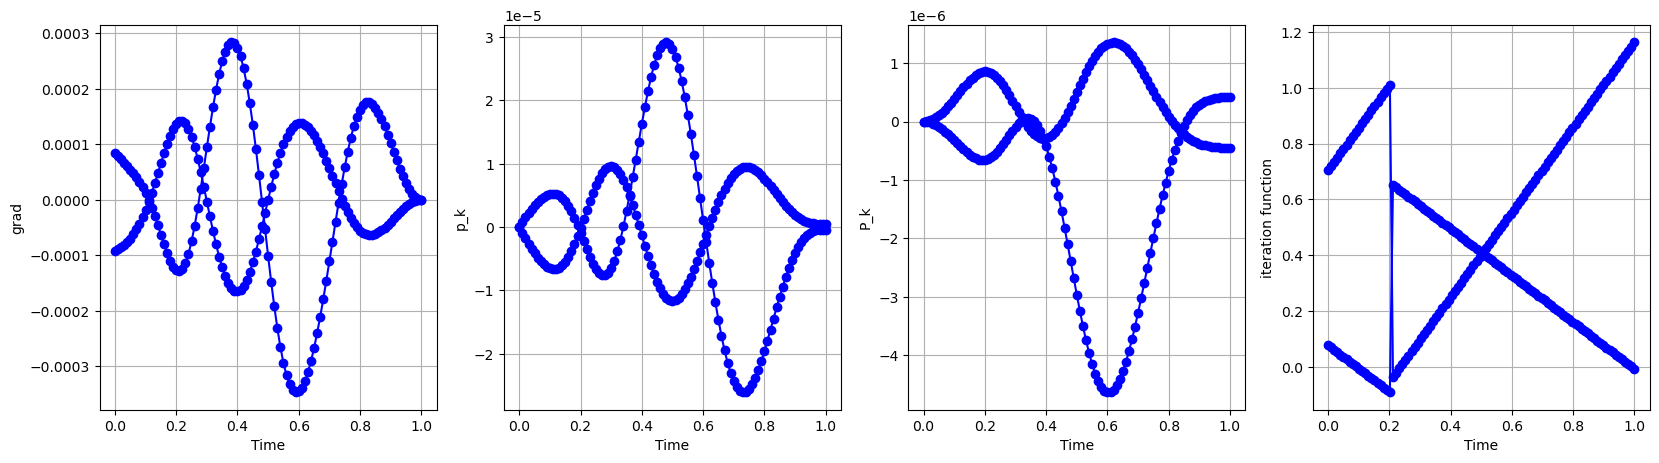

|p_max|/alpha:  31.182092346359884 , |P_max|/beta:  0.04820604683304062
x_S:  0.48 x_K:  0.6 
New point: sigma= [-0.35643172  0.93432137] x_0 = 0.48 , type = 0
weights:  [5.96286639e-07 1.30668831e-06] slope:  [ 0.58805818 -1.34381334] y_shift [-0.00864977  0.95881181]
Objective:  0.00011280036064310943
2 : Active set:
	 0 sigma= [ 0.57695517 -0.81677582] ,	x_0 = 0.21 ,	type = 0 	weight: 5.962866390137347e-07 	id: 140627273538096
	 1 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.306688310576175e-06 	id: 140627272111056
slope:  [ 0.58805818 -1.34381334] y_shift [-0.00864977  0.95881181]
2 : Hesse condition: 1430679412179408.8


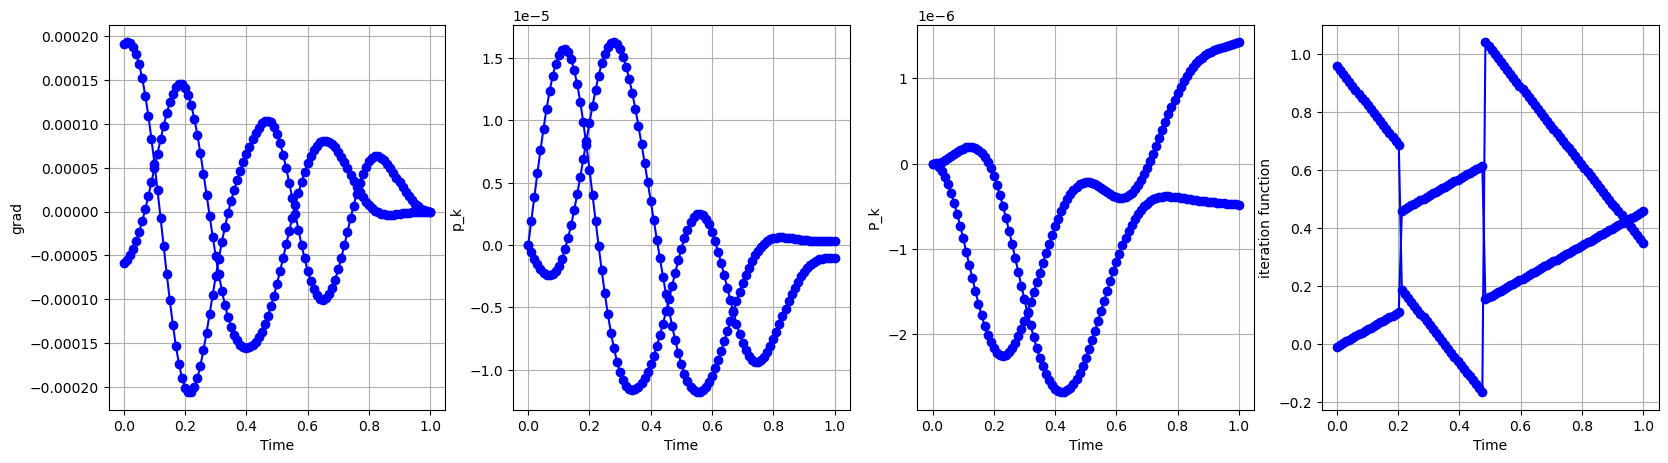

|p_max|/alpha:  18.7394595123509 , |P_max|/beta:  0.027451588273609905
x_S:  0.3 x_K:  0.41000000000000003 
New point: sigma= [ 0.83848577 -0.54492349] x_0 = 0.3 , type = 0
weights:  [5.61033125e-07 1.05145014e-06 5.13363684e-07] slope:  [-0.34225792 -0.4535822 ] y_shift [0.07143227 0.85095313]
Objective:  0.00011065714363720201
3 : Active set:
	 0 sigma= [ 0.57695517 -0.81677582] ,	x_0 = 0.21 ,	type = 0 	weight: 5.610331253202665e-07 	id: 140627273538096
	 1 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0514501390977272e-06 	id: 140627272111056
	 2 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 5.133636835688482e-07 	id: 140627272335280
slope:  [-0.34225792 -0.4535822 ] y_shift [0.07143227 0.85095313]
3 : Hesse condition: 2137261510826918.8


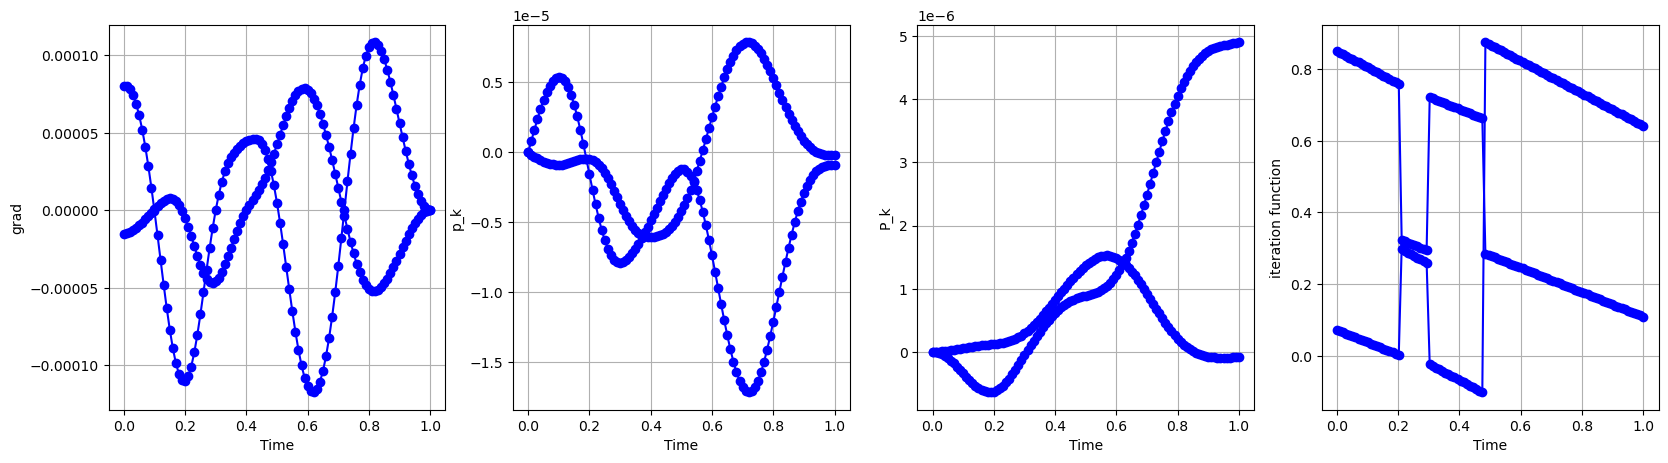

|p_max|/alpha:  18.84695102174004 , |P_max|/beta:  0.04891469921706762
x_S:  0.72 x_K:  0.99 
New point: sigma= [ 0.41737522 -0.90873424] x_0 = 0.72 , type = 0
weights:  [7.49975594e-07 1.01571802e-06 3.55192426e-07 5.03854445e-07] slope:  [-0.3266377  -0.05211038] y_shift [0.05132953 0.80984518]
Objective:  0.00010819949412327219
4 : Active set:
	 0 sigma= [ 0.57695517 -0.81677582] ,	x_0 = 0.21 ,	type = 0 	weight: 7.499755937510866e-07 	id: 140627273538096
	 1 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0157180195270147e-06 	id: 140627272111056
	 2 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.551924263189752e-07 	id: 140627272335280
	 3 sigma= [ 0.41737522 -0.90873424] ,	x_0 = 0.72 ,	type = 0 	weight: 5.038544451975251e-07 	id: 140627287649712
slope:  [-0.3266377  -0.05211038] y_shift [0.05132953 0.80984518]
4 : Hesse condition: 7406874018877439.0


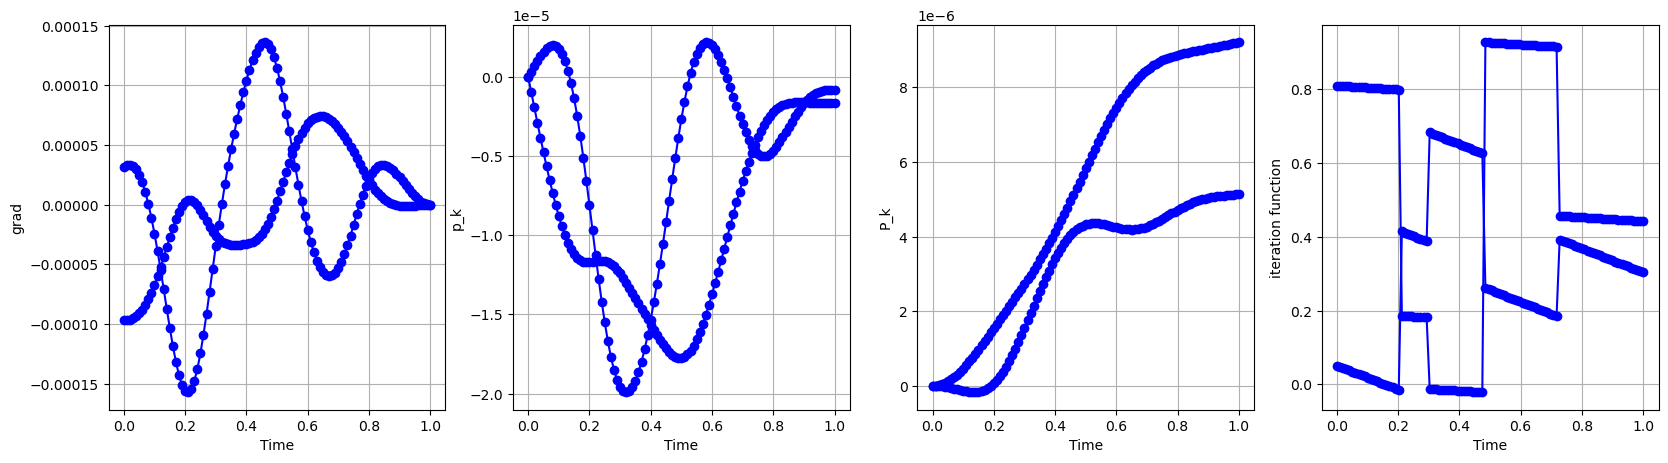

|p_max|/alpha:  23.870998803004582 , |P_max|/beta:  0.10527008412313908
x_S:  0.33 x_K:  0.99 
New point: sigma= [-0.55720634 -0.83037407] x_0 = 0.33 , type = 0
weights:  [4.44939718e-07 1.18749168e-06 5.98312417e-07 5.72346855e-07
 3.53196662e-07] slope:  [-0.0236175   0.12645918] y_shift [0.06854838 0.74883021]
Objective:  0.0001074559182403311
5 : Active set:
	 0 sigma= [ 0.57695517 -0.81677582] ,	x_0 = 0.21 ,	type = 0 	weight: 4.4493971815806513e-07 	id: 140627273538096
	 1 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1874916838044156e-06 	id: 140627272111056
	 2 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 5.983124174097436e-07 	id: 140627272335280
	 3 sigma= [ 0.41737522 -0.90873424] ,	x_0 = 0.72 ,	type = 0 	weight: 5.723468549105708e-07 	id: 140627287649712
	 4 sigma= [-0.55720634 -0.83037407] ,	x_0 = 0.33 ,	type = 0 	weight: 3.5319666177412413e-07 	id: 140627267549808
slope:  [-0.0236175   0.12645918] y_shift [0.06854838 0.74883021]
5 

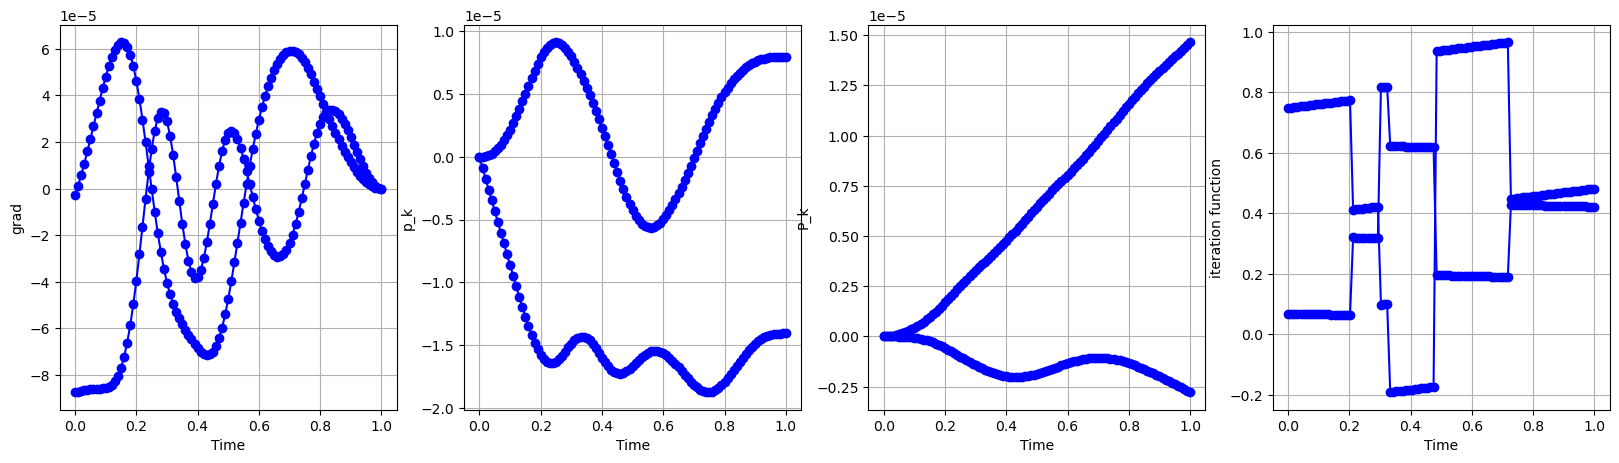

|p_max|/alpha:  19.007832216624195 , |P_max|/beta:  0.14756153200298497
x_S:  0.76 x_K:  0.99 
New point: sigma= [ 0.17402233 -0.98474171] x_0 = 0.76 , type = 0
weights:  [2.96466942e-07 1.16085579e-06 6.77258761e-07 3.34367230e-08
 3.81023305e-07 7.00485577e-07] slope:  [0.02274638 0.14384766] y_shift [0.09163229 0.69809961]
Objective:  0.000108692675351495
6 : Active set:
	 0 sigma= [ 0.57695517 -0.81677582] ,	x_0 = 0.21 ,	type = 0 	weight: 2.964669422491702e-07 	id: 140627273538096
	 1 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.160855790141355e-06 	id: 140627272111056
	 2 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 6.772587605078014e-07 	id: 140627272335280
	 3 sigma= [-0.55720634 -0.83037407] ,	x_0 = 0.33 ,	type = 0 	weight: 3.810233051203692e-07 	id: 140627267549808
	 4 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.004855769136168e-07 	id: 140627272536368
slope:  [0.02274638 0.14384766] y_shift [0.09163229 0.69809

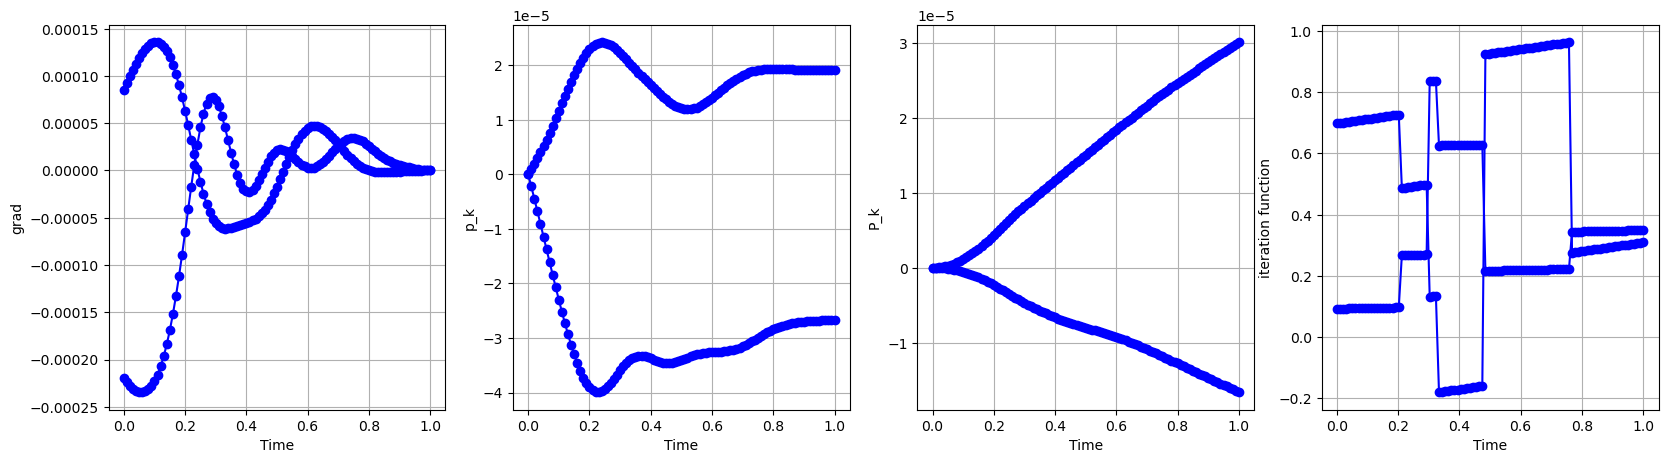

|p_max|/alpha:  46.63759674975371 , |P_max|/beta:  0.34005258799019233
x_S:  0.23 x_K:  0.99 
New point: sigma= [ 0.51623666 -0.85644597] x_0 = 0.23 , type = 0
weights:  [8.23092533e-10 1.14125614e-06 6.20718375e-07 3.27358512e-07
 7.36711316e-07 3.32678844e-07] slope:  [0.02555484 0.14262215] y_shift [0.10552491 0.68447168]
Objective:  0.0001091145652723235
7 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1412561379406072e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 6.207183749437907e-07 	id: 140627272335280
	 2 sigma= [-0.55720634 -0.83037407] ,	x_0 = 0.33 ,	type = 0 	weight: 3.27358511841604e-07 	id: 140627267549808
	 3 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.367113163746535e-07 	id: 140627272536368
	 4 sigma= [ 0.51623666 -0.85644597] ,	x_0 = 0.23 ,	type = 0 	weight: 3.3267884440397963e-07 	id: 140627263952592
slope:  [0.02555484 0.14262215] y_shift [0.10552491 0.6844

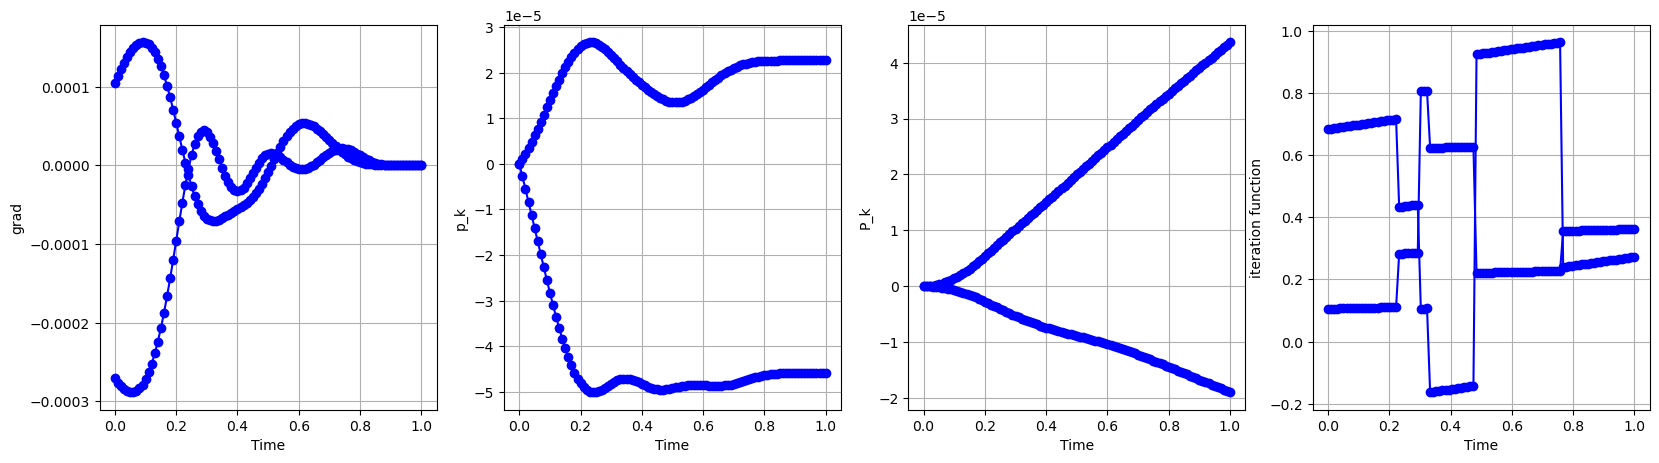

|p_max|/alpha:  56.738737448794986 , |P_max|/beta:  0.47061984984997346
x_S:  0.24 x_K:  0.99 
New point: sigma= [ 0.4694838  -0.88294109] x_0 = 0.24 , type = 0
weights:  [1.13104503e-06 5.79216996e-07 2.92592298e-07 7.35347136e-07
 1.25797710e-07 2.48688896e-07] slope:  [0.02676904 0.1440173 ] y_shift [0.10912706 0.68351231]
Objective:  0.00010911558451626428
8 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1310450305051058e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 5.792169961732519e-07 	id: 140627272335280
	 2 sigma= [-0.55720634 -0.83037407] ,	x_0 = 0.33 ,	type = 0 	weight: 2.925922975305585e-07 	id: 140627267549808
	 3 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.353471363436177e-07 	id: 140627272536368
	 4 sigma= [ 0.51623666 -0.85644597] ,	x_0 = 0.23 ,	type = 0 	weight: 1.2579770997170278e-07 	id: 140627263952592
	 5 sigma= [ 0.4694838  -0.88294109] ,	x_0 = 0.24 ,	typ

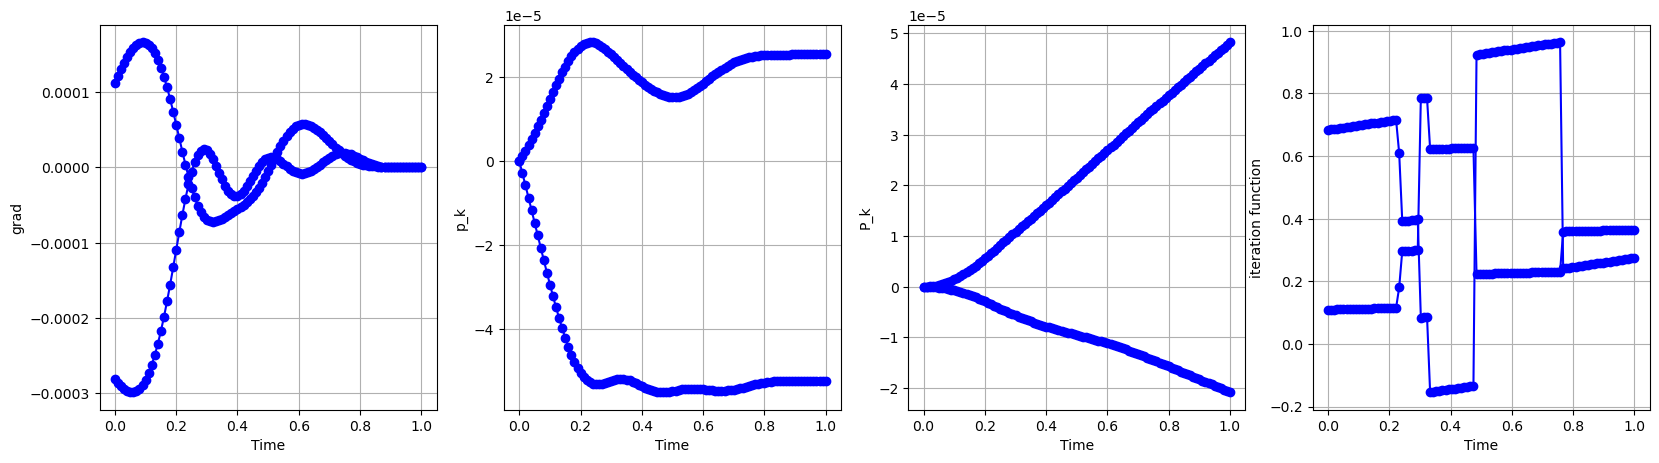

|p_max|/alpha:  60.04547741448575 , |P_max|/beta:  0.5194426088116895
x_S:  0.25 x_K:  0.99 
New point: sigma= [ 0.46777128 -0.88384955] x_0 = 0.25 , type = 0
weights:  [1.11274282e-06 6.24364910e-07 3.21348487e-07 7.71592301e-07
 0.00000000e+00 6.91576872e-08 1.50348030e-07] slope:  [0.04528437 0.14387177] y_shift [0.14781523 0.61892512]
Objective:  0.00012202738084501877
9 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.112742816474405e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 6.243649098078121e-07 	id: 140627272335280
	 2 sigma= [-0.55720634 -0.83037407] ,	x_0 = 0.33 ,	type = 0 	weight: 3.2134848668769267e-07 	id: 140627267549808
	 3 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.715923005817851e-07 	id: 140627272536368
	 4 sigma= [ 0.46777128 -0.88384955] ,	x_0 = 0.25 ,	type = 0 	weight: 1.5034802968902913e-07 	id: 140627268041136
slope:  [0.04528437 0.14387177] y_shift [0

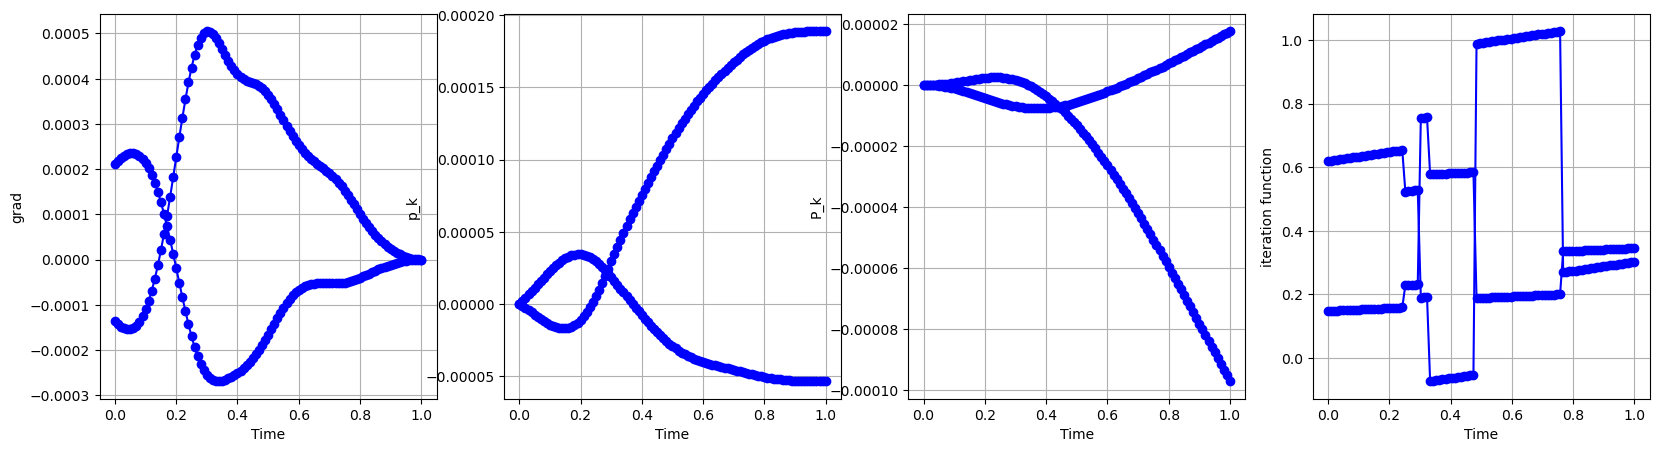

|p_max|/alpha:  196.32091200835424 , |P_max|/beta:  0.9671934560048088
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.27275129  0.96208458] x_0 = 0.99 , type = 0
weights:  [1.08421514e-06 2.35076346e-07 5.85853982e-08 6.69408412e-07
 8.46852918e-07 0.00000000e+00] slope:  [-0.02381564  0.11891605] y_shift [0.07929009 0.76131925]
Objective:  0.0001100913125071916
10 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0842151355690597e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.3507634560395597e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.694084116761446e-07 	id: 140627272536368
	 3 sigma= [ 0.46777128 -0.88384955] ,	x_0 = 0.25 ,	type = 0 	weight: 8.468529180247014e-07 	id: 140627268041136
slope:  [-0.02381564  0.11891605] y_shift [0.07929009 0.76131925]
10 : Hesse condition: 5223372995004198.0


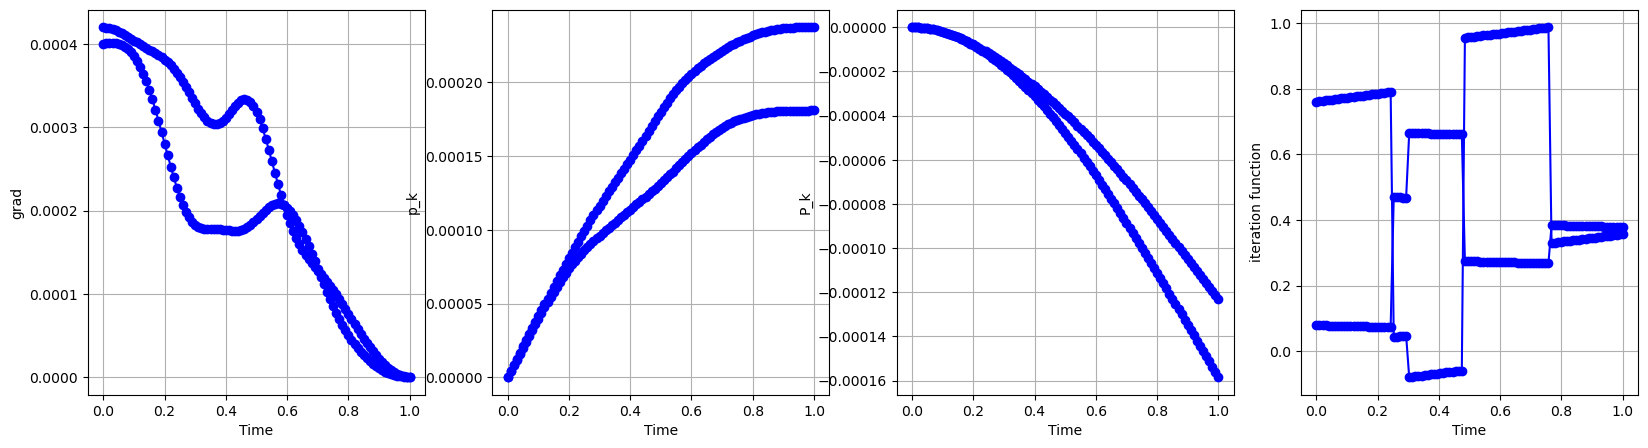

|p_max|/alpha:  298.5549684330032 , |P_max|/beta:  1.9751424213457527
x_S:  0.99 x_K:  0.99 
New point: sigma= [0.60612671 0.7953681 ] x_0 = 0.99 , type = 0
weights:  [1.06200882e-06 1.48049004e-07 6.55365781e-07 9.30587054e-07
 0.00000000e+00] slope:  [-0.02228299  0.09684292] y_shift [0.07568233 0.77072241]
Objective:  0.00010609096538833558
11 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0620088248825393e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 1.4804900394408515e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.553657807539449e-07 	id: 140627272536368
	 3 sigma= [ 0.46777128 -0.88384955] ,	x_0 = 0.25 ,	type = 0 	weight: 9.305870544473548e-07 	id: 140627268041136
slope:  [-0.02228299  0.09684292] y_shift [0.07568233 0.77072241]
11 : Hesse condition: 5223372995004198.0


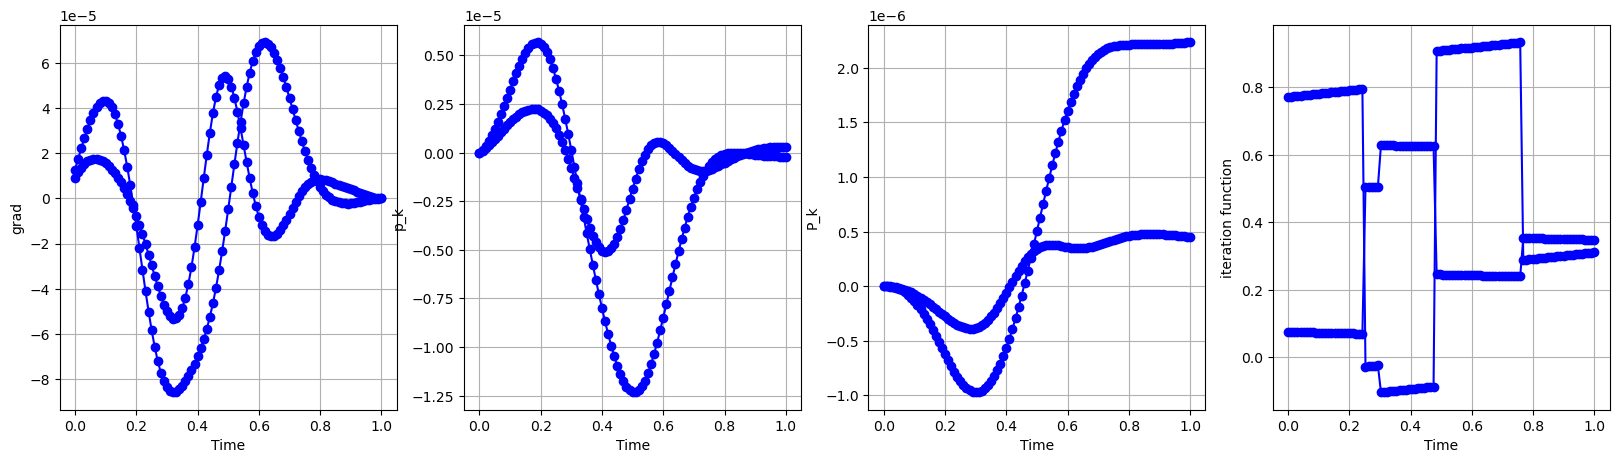

|p_max|/alpha:  12.466699197929803 , |P_max|/beta:  0.02279061459295382
x_S:  0.5 x_K:  0.99 
New point: sigma= [-0.98885747 -0.14886539] x_0 = 0.5 , type = 0
weights:  [1.02899447e-06 2.58021191e-07 6.66345866e-07 8.37224809e-07
 1.44020401e-07] slope:  [0.03327858 0.15407109] y_shift [0.06712951 0.74637303]
Objective:  0.00010542397507273764
12 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0289944656726358e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.5802119067703974e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.663458663676623e-07 	id: 140627272536368
	 3 sigma= [ 0.46777128 -0.88384955] ,	x_0 = 0.25 ,	type = 0 	weight: 8.372248086821326e-07 	id: 140627268041136
	 4 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4402040092514557e-07 	id: 140627289922624
slope:  [0.03327858 0.15407109] y_shift [0.06712951 0.74637303]
12 : He

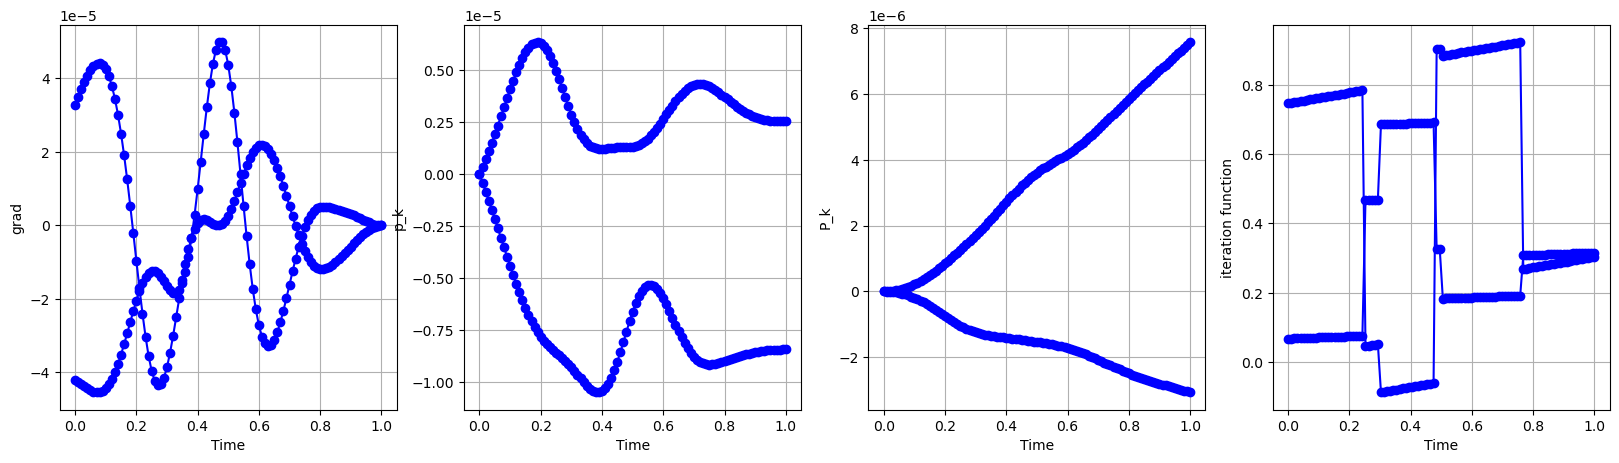

|p_max|/alpha:  10.57635382574816 , |P_max|/beta:  0.08069932012625396
x_S:  0.39 x_K:  0.99 
New point: sigma= [ 0.11428155 -0.9934484 ] x_0 = 0.39 , type = 0
weights:  [1.10712135e-06 3.26304531e-07 7.17160990e-07 6.40669506e-07
 1.35055206e-07 1.41272313e-07] slope:  [0.04317678 0.15740989] y_shift [0.09250283 0.69363161]
Objective:  0.00010728877201410298
13 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1071213480279124e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.2630453074530045e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.171609895555127e-07 	id: 140627272536368
	 3 sigma= [ 0.46777128 -0.88384955] ,	x_0 = 0.25 ,	type = 0 	weight: 6.406695063072781e-07 	id: 140627268041136
	 4 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.350552058696898e-07 	id: 140627289922624
	 5 sigma= [ 0.11428155 -0.9934484 ] ,	x_0 = 0.39 ,	type

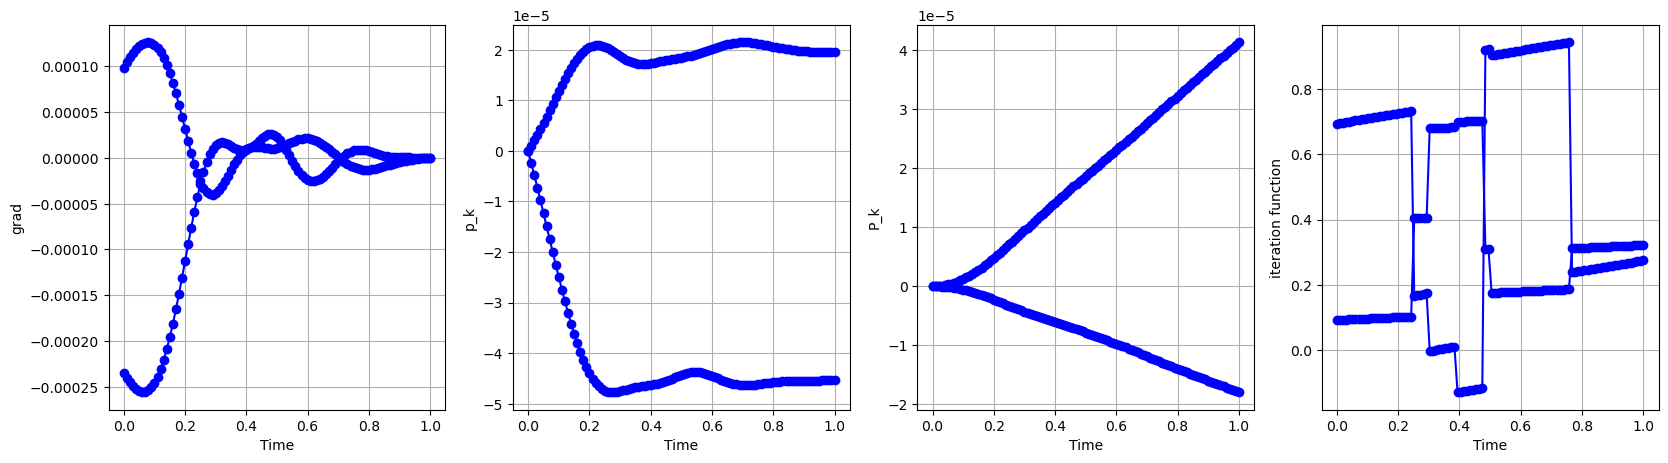

|p_max|/alpha:  51.79633558337172 , |P_max|/beta:  0.44637382532903613
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.39186666 -0.92002202] x_0 = 0.26 , type = 0
weights:  [1.11921488e-06 3.92703368e-07 7.63624395e-07 1.29423309e-07
 1.32982254e-07 1.87507465e-07 3.20925963e-07] slope:  [0.05437876 0.15334884] y_shift [0.13443155 0.62652631]
Objective:  0.00011375624514028714
14 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1192148764293299e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.9270336759499237e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.636243948020036e-07 	id: 140627272536368
	 3 sigma= [ 0.46777128 -0.88384955] ,	x_0 = 0.25 ,	type = 0 	weight: 1.2942330946320642e-07 	id: 140627268041136
	 4 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3298225375716644e-07 	id: 140627289922624
	 5 sigma= [ 0.11428155 -0.9934484 ] ,	

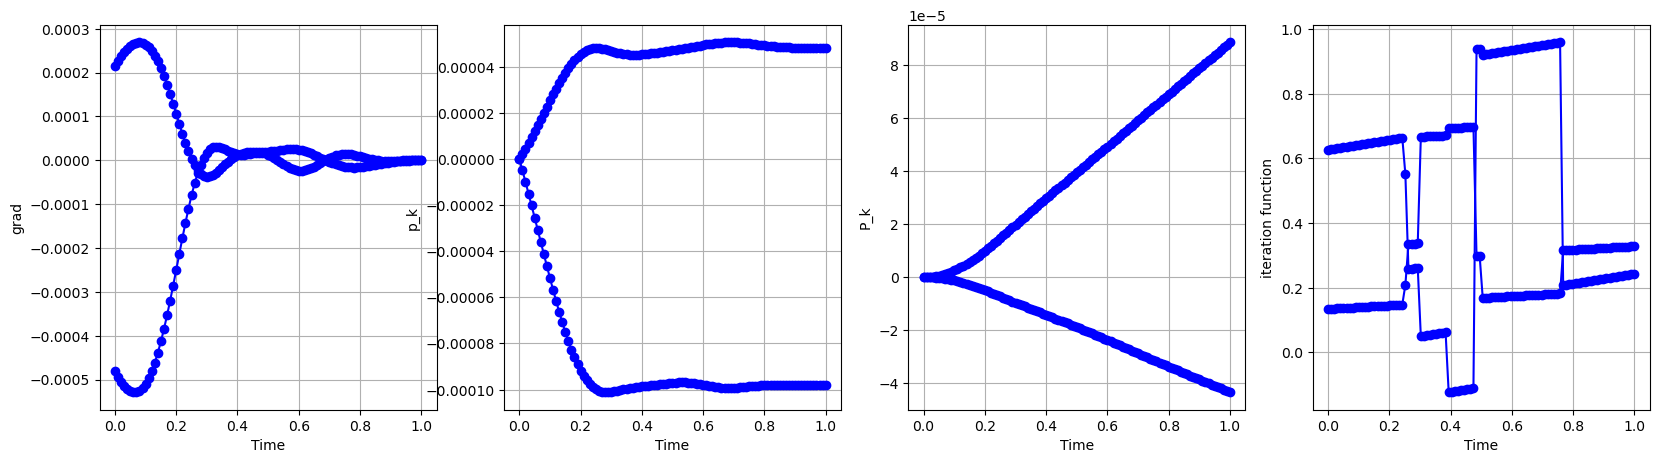

|p_max|/alpha:  111.77176931198534 , |P_max|/beta:  0.975795741161908
x_S:  0.28 x_K:  0.99 
New point: sigma= [ 0.4257493  -0.90484117] x_0 = 0.28 , type = 0
weights:  [1.04390580e-06 3.07353530e-07 7.19354636e-07 2.39958863e-08
 1.48194176e-07 0.00000000e+00 2.05032017e-07 4.63790562e-07] slope:  [0.05655006 0.16248704] y_shift [0.11905841 0.66008461]
Objective:  0.00011065407283786092
15 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0439058033835368e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.0735352978581184e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.193546361706375e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4819417572387513e-07 	id: 140627289922624
	 4 sigma= [ 0.39186666 -0.92002202] ,	x_0 = 0.26 ,	type = 0 	weight: 2.0503201659061986e-07 	id: 140627268924096
	 5 sigma= [ 0.4257493  -

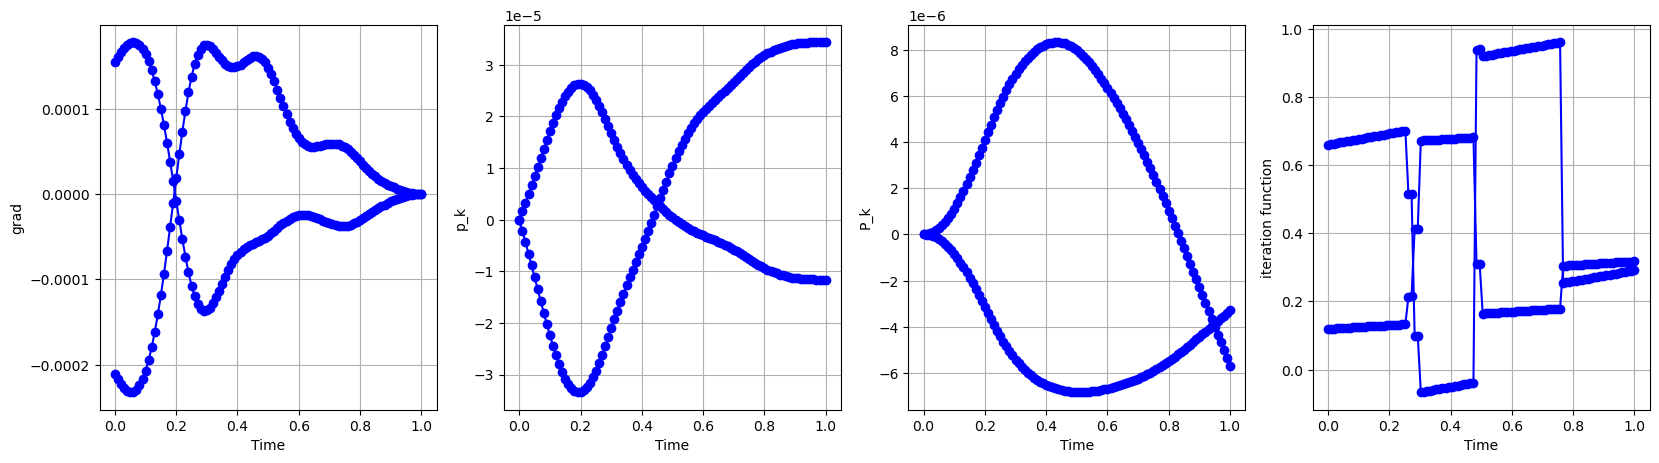

|p_max|/alpha:  42.505818902956335 , |P_max|/beta:  0.10712584763530945
x_S:  0.19 x_K:  0.45 
New point: sigma= [ 0.6176803 -0.7864293] x_0 = 0.19 , type = 0
weights:  [1.01802513e-06 3.32272650e-07 7.35807466e-07 1.58514875e-07
 1.68329648e-07 4.25844788e-07 1.34269946e-08] slope:  [0.05176291 0.15252976] y_shift [0.13107806 0.63291326]
Objective:  0.00011292109731452672
16 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0180251285177082e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.322726499183796e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.358074660231744e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.5851487506223396e-07 	id: 140627289922624
	 4 sigma= [ 0.39186666 -0.92002202] ,	x_0 = 0.26 ,	type = 0 	weight: 1.6832964826091142e-07 	id: 140627268924096
	 5 sigma= [ 0.4257493  -0.90484117] ,	x_

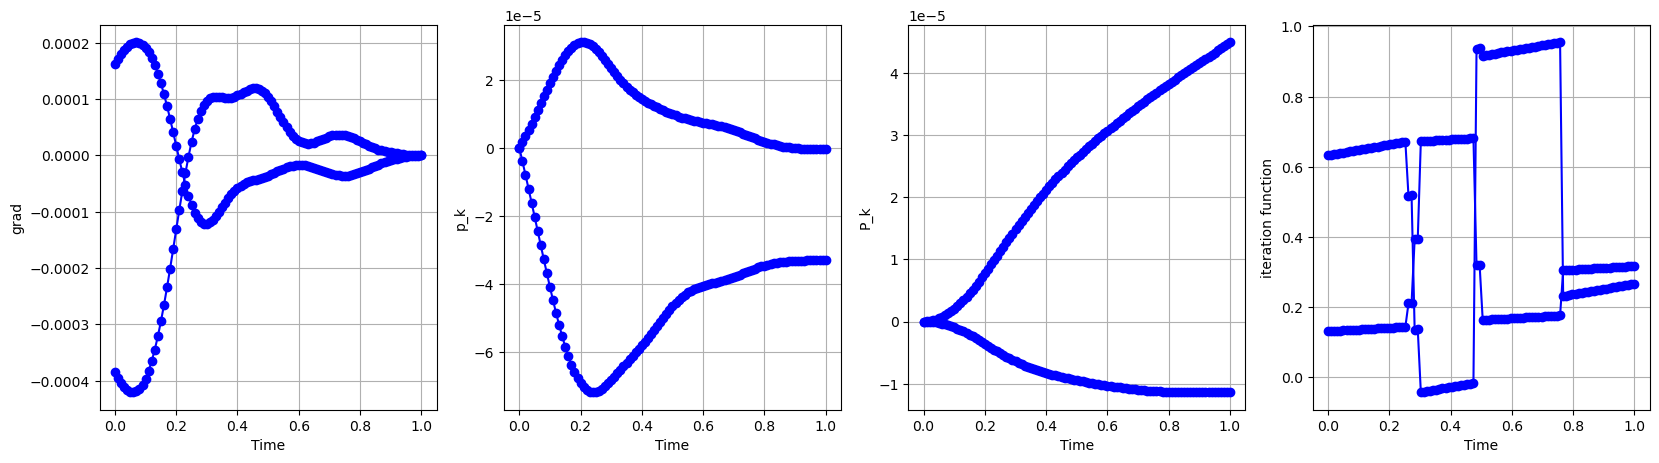

|p_max|/alpha:  77.99437223970023 , |P_max|/beta:  0.460694834002387
x_S:  0.23 x_K:  0.99 
New point: sigma= [ 0.3913347  -0.92024842] x_0 = 0.23 , type = 0
weights:  [1.00785379e-06 3.22717919e-07 7.41783422e-07 1.55064717e-07
 1.94832005e-07 3.84806728e-07 9.25234289e-09] slope:  [0.05515268 0.15275829] y_shift [0.14055001 0.62334344]
Objective:  0.00011412317400073631
17 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0078537905770395e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.2271791924735383e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.417834223077928e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.550647169143385e-07 	id: 140627289922624
	 4 sigma= [ 0.39186666 -0.92002202] ,	x_0 = 0.26 ,	type = 0 	weight: 1.9483200534955962e-07 	id: 140627268924096
	 5 sigma= [ 0.4257493  -0.90484117] ,	x_0

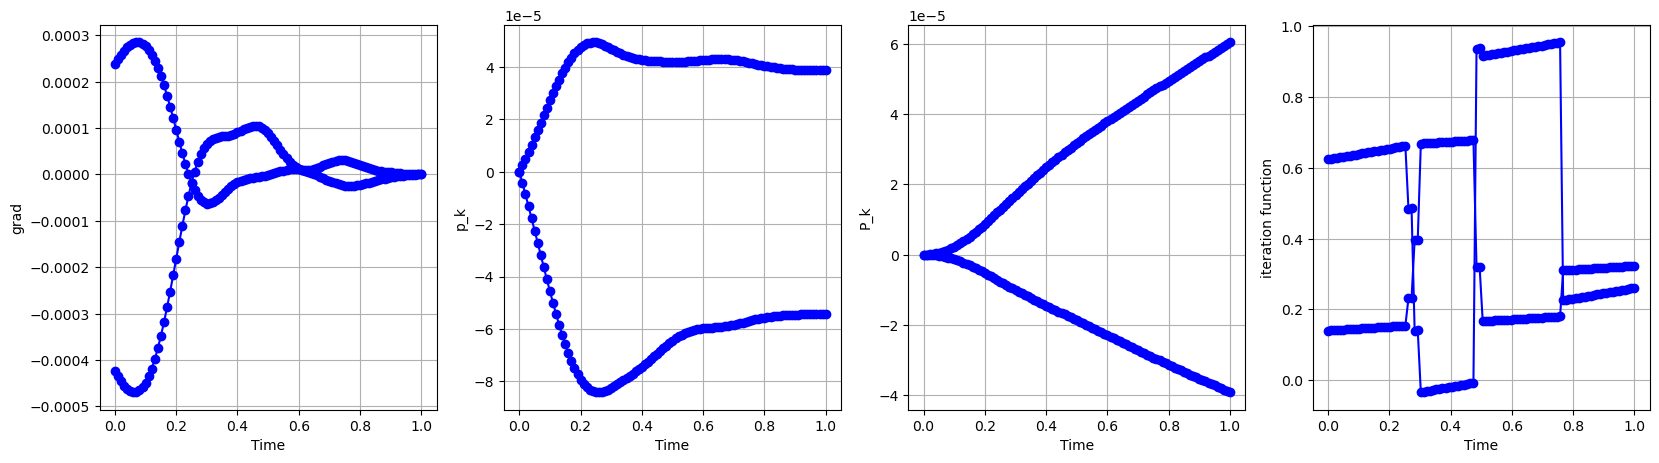

|p_max|/alpha:  97.47029873078536 , |P_max|/beta:  0.7146609901908278
x_S:  0.25 x_K:  0.99 
New point: sigma= [ 0.50584082 -0.86262684] x_0 = 0.25 , type = 0
weights:  [1.01161090e-06 3.29404193e-07 7.40570922e-07 1.57921098e-07
 1.85882480e-07 4.03444677e-07 6.33323304e-10] slope:  [0.05432426 0.15283263] y_shift [0.13848635 0.62409816]
Objective:  0.00011377150531330149
18 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0116109005915067e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.294041933258874e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.405709215994411e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.5792109789010617e-07 	id: 140627289922624
	 4 sigma= [ 0.39186666 -0.92002202] ,	x_0 = 0.26 ,	type = 0 	weight: 1.8588247987076082e-07 	id: 140627268924096
	 5 sigma= [ 0.4257493  -0.90484117] ,	x_

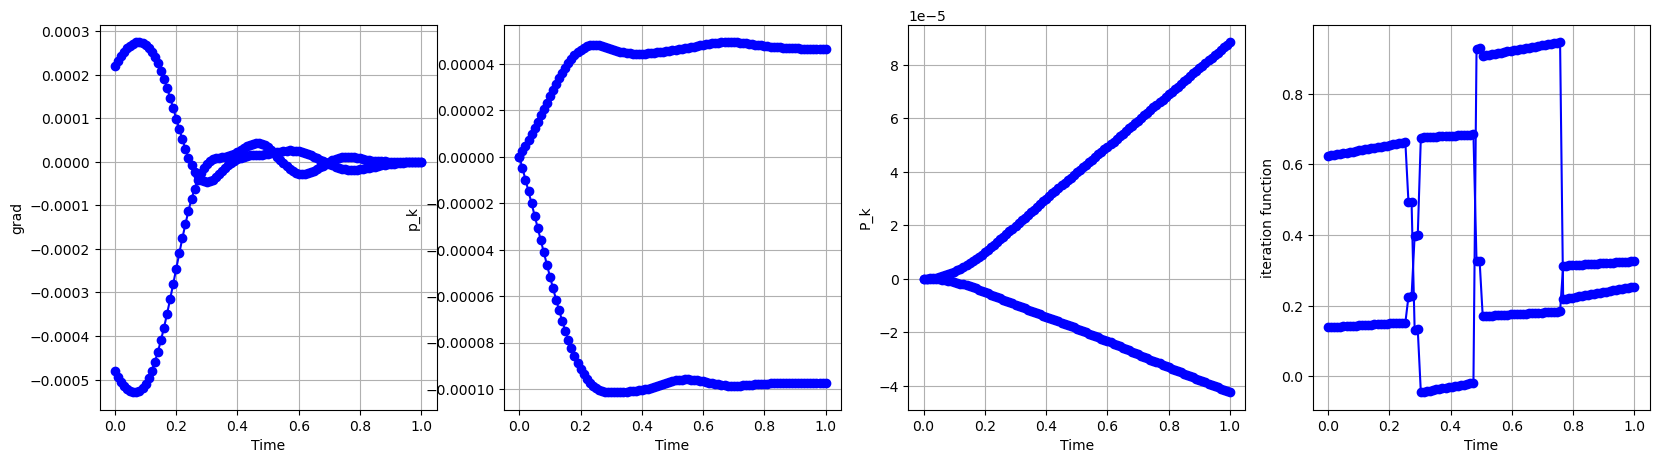

|p_max|/alpha:  111.6015097853385 , |P_max|/beta:  0.970591861709983
x_S:  0.29 x_K:  0.99 
New point: sigma= [ 0.41994472 -0.90754968] x_0 = 0.29 , type = 0
weights:  [1.03903769e-06 3.05529101e-07 7.42379355e-07 1.48574686e-07
 9.16541045e-08 2.43397286e-07 2.96626100e-07] slope:  [0.05555356 0.153225  ] y_shift [0.14088915 0.62365518]
Objective:  0.00012681490232527949
19 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0390376855237331e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 3.055291006685946e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.42379354979226e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4857468601369273e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.433972861108868e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 =

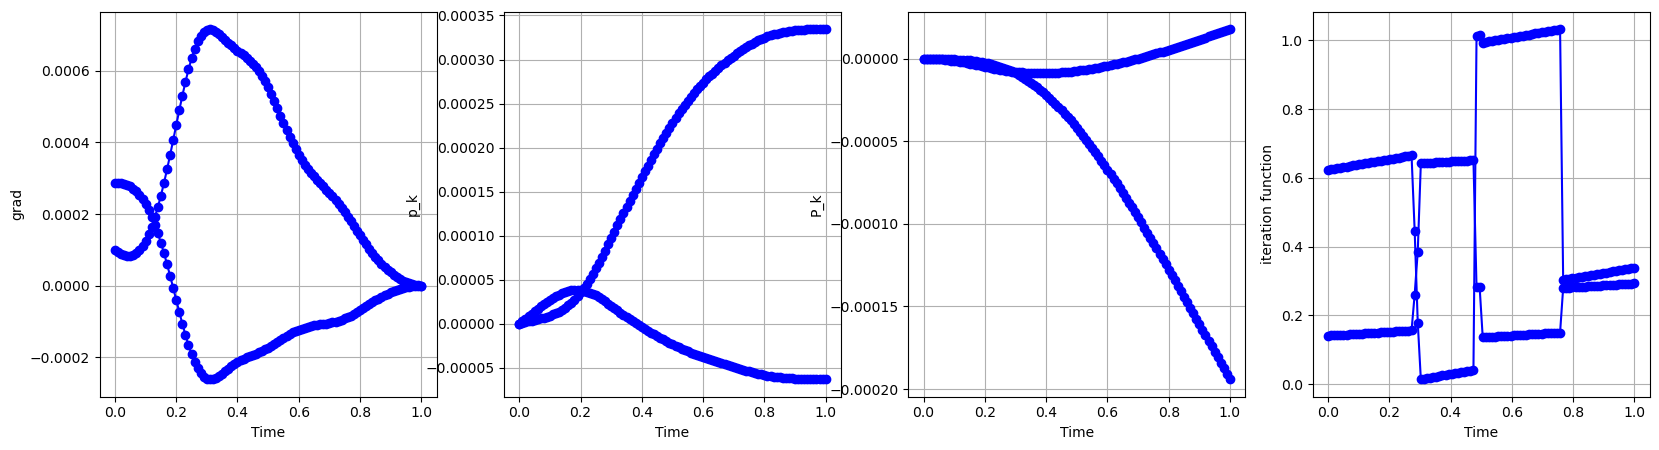

|p_max|/alpha:  340.2479954676314 , |P_max|/beta:  1.9151706507764885
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.18499806  0.98273889] x_0 = 0.99 , type = 0
weights:  [1.13128365e-06 2.82307582e-07 6.77878092e-07 1.34145115e-07
 6.99917630e-07 1.54907676e-07 0.00000000e+00] slope:  [0.05308751 0.14116958] y_shift [0.09274932 0.71286042]
Objective:  0.00010806391435604314
20 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.131283647923614e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.823075822727121e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778780915477604e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3414511537470253e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999176298531396e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 

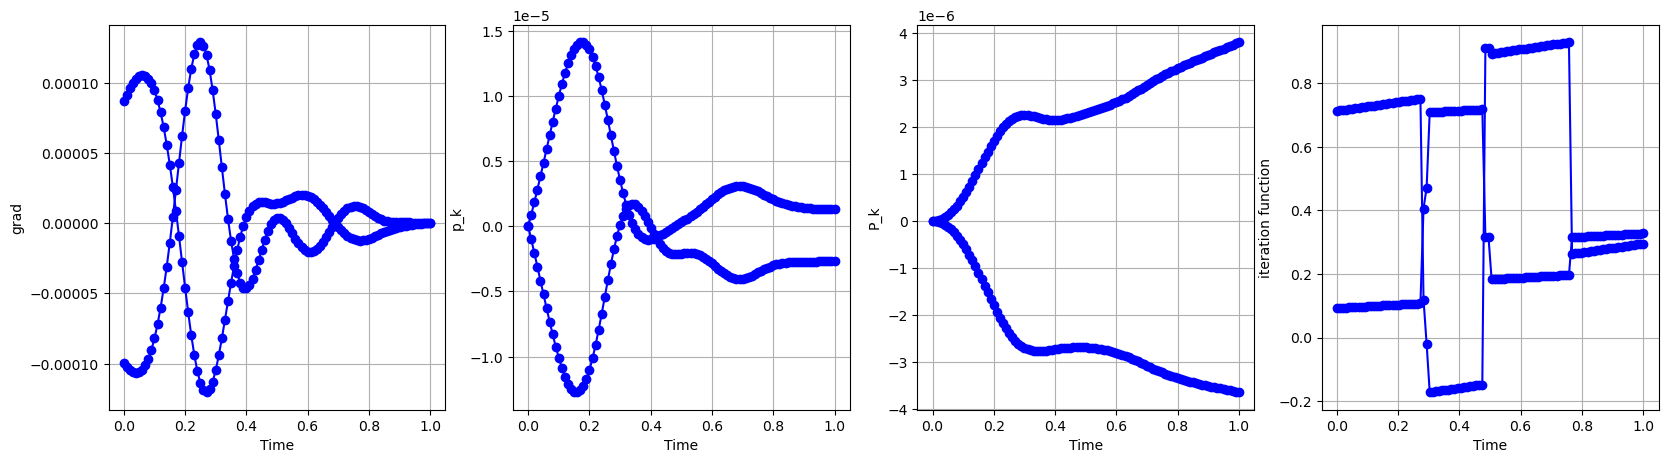

|p_max|/alpha:  18.912444966481637 , |P_max|/beta:  0.052341542049598906
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74606338 -0.66587494] x_0 = 0.17 , type = 0
weights:  [1.05834180e-06 2.99995029e-07 7.35028153e-07 1.48703541e-07
 3.05714087e-07 3.56441899e-07 1.64545069e-08] slope:  [0.05066874 0.15400046] y_shift [0.12906114 0.63731175]
Objective:  0.00011274962433733885
21 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.058341799347198e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.999950290317658e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350281530823661e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4870354117586004e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.057140868263655e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x

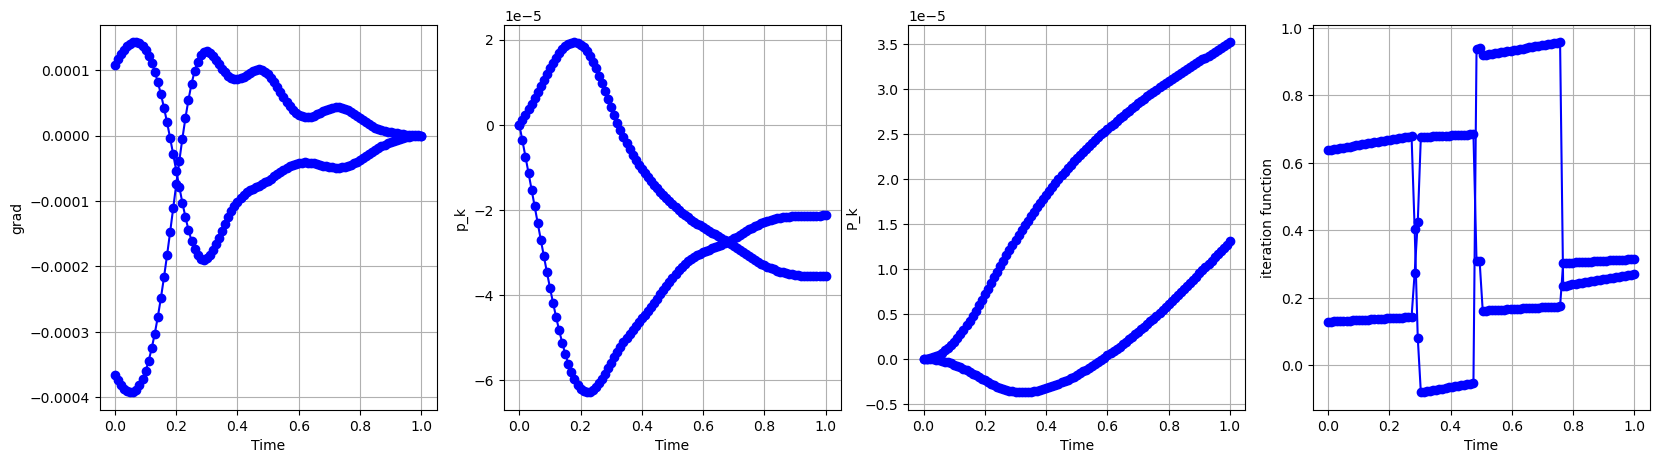

|p_max|/alpha:  65.1617659784933 , |P_max|/beta:  0.3723778928227952
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27824624 -0.96050978] x_0 = 0.21 , type = 0
weights:  [1.04635273e-06 2.81899450e-07 7.46679914e-07 1.41409047e-07
 3.02494238e-07 3.42485112e-07 2.63520471e-09] slope:  [0.05822248 0.15341352] y_shift [0.14587832 0.61867073]
Objective:  0.00011459630601254336
22 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0463527264526168e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.818994501738969e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.466799140818247e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4140904670588248e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.0249423829093604e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

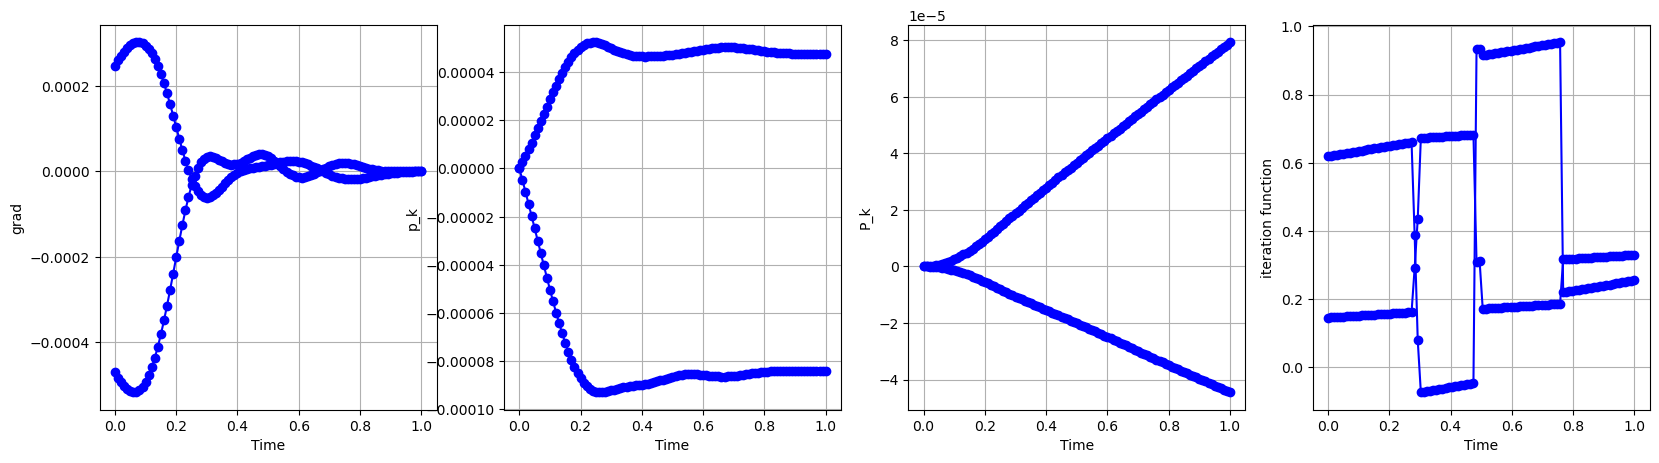

|p_max|/alpha:  106.59562810443647 , |P_max|/beta:  0.8994816472484032
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.4889965  -0.87228575] x_0 = 0.26 , type = 0
weights:  [1.04293967e-06 2.88491842e-07 7.39784160e-07 1.47435167e-07
 2.61645703e-07 3.03412048e-07 9.11294924e-08] slope:  [0.05404005 0.1531711 ] y_shift [0.13761178 0.62774667]
Objective:  0.00012593432257335398
23 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.042939671081282e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.884918421453028e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.397841597020169e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4743516699147392e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.6164570307240193e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_

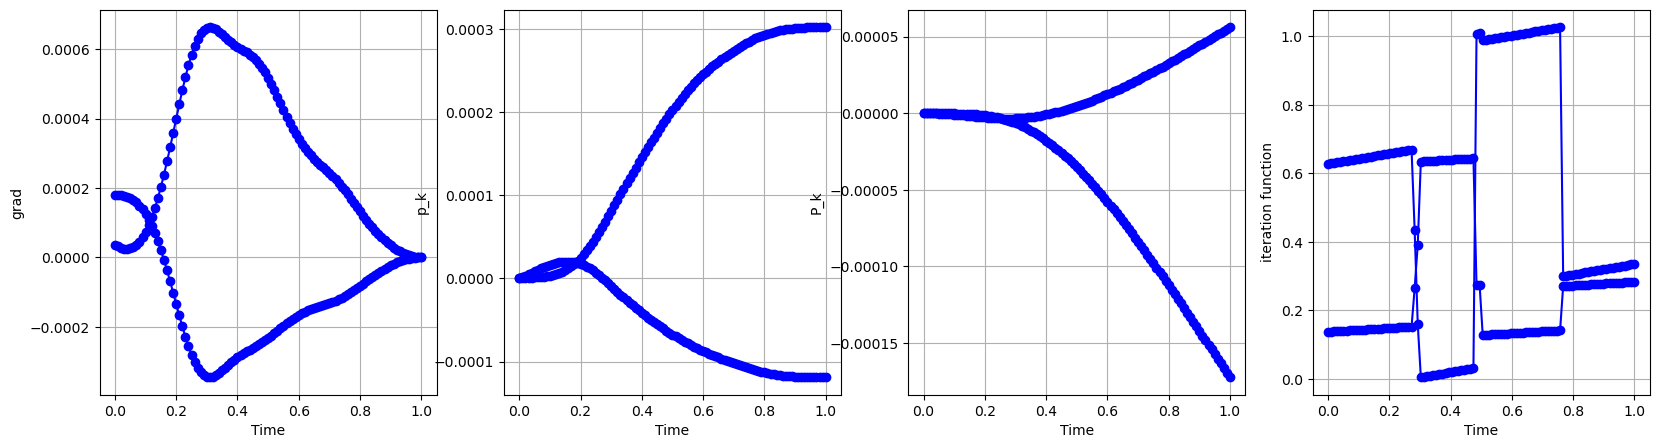

|p_max|/alpha:  324.77012178644867 , |P_max|/beta:  1.780930535008145
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.36567934  0.9307409 ] x_0 = 0.99 , type = 0
weights:  [1.13132617e-06 2.82770494e-07 6.77846913e-07 1.33872387e-07
 6.99910039e-07 1.54595338e-07 0.00000000e+00] slope:  [0.05219046 0.14095486] y_shift [0.09285842 0.71288495]
Objective:  0.00010806568198273668
24 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1313261722972035e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.827704943663859e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778469134118076e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3387238663571955e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999100393083018e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

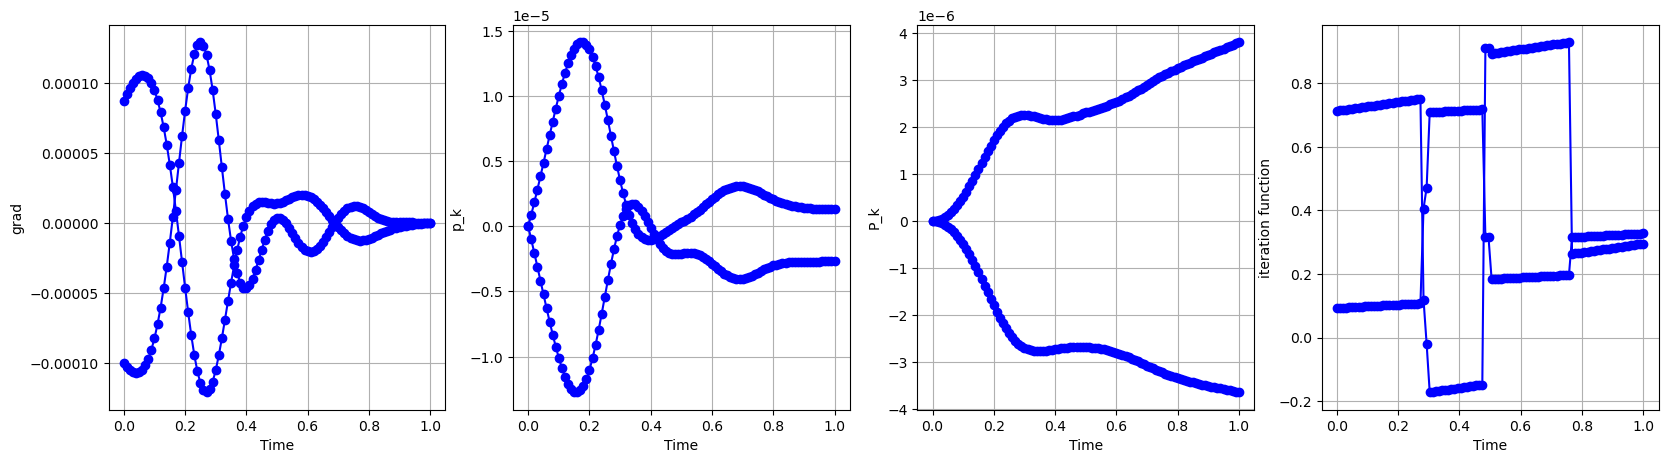

|p_max|/alpha:  18.917765204702448 , |P_max|/beta:  0.052343468724340245
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74647391 -0.66541469] x_0 = 0.17 , type = 0
weights:  [1.05833574e-06 2.99970856e-07 7.35032277e-07 1.48699530e-07
 3.05768597e-07 3.56405621e-07 1.64483877e-08] slope:  [0.05066633 0.15400553] y_shift [0.12906537 0.63730524]
Objective:  0.00011274977498007553
25 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0583357448770357e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.999708561018183e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350322774346294e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4869952972922743e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.0576859701747764e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,

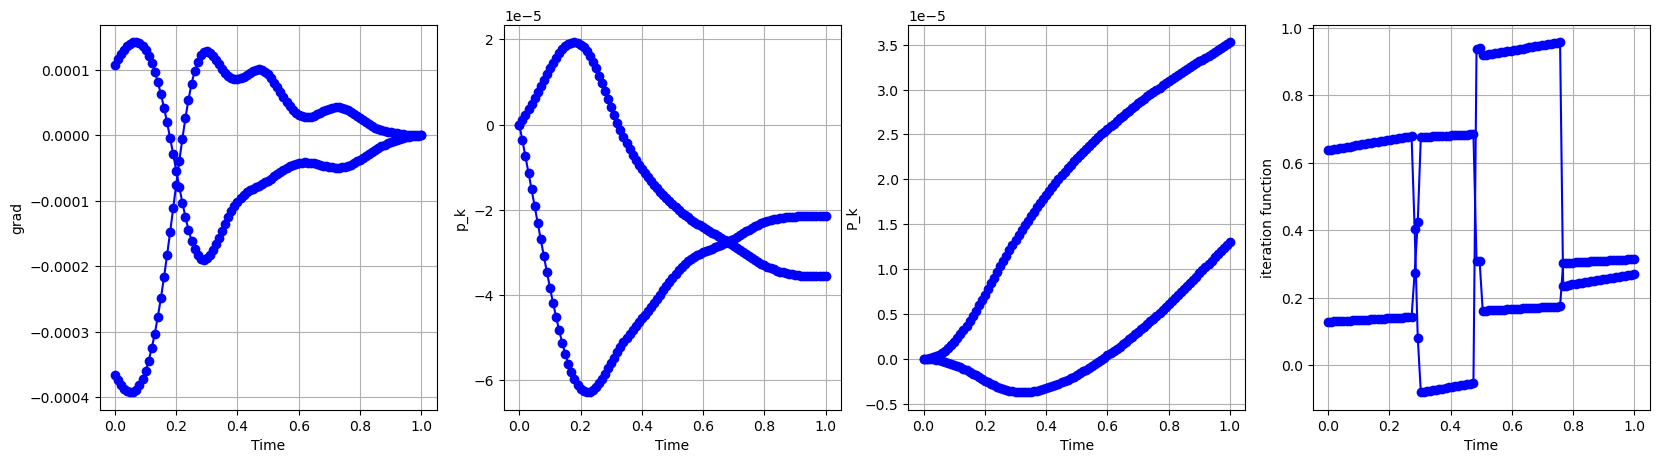

|p_max|/alpha:  65.19145696964864 , |P_max|/beta:  0.3730161437594253
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27794224 -0.96059779] x_0 = 0.21 , type = 0
weights:  [1.04634787e-06 2.81854219e-07 7.46681537e-07 1.41399009e-07
 3.02670448e-07 3.42365539e-07 2.59784664e-09] slope:  [0.05822594 0.15341425] y_shift [0.14588771 0.61866361]
Objective:  0.00011459708900142159
26 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0463478674466938e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8185421911106773e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.46681536886319e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4139900883799623e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.026704484362947e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

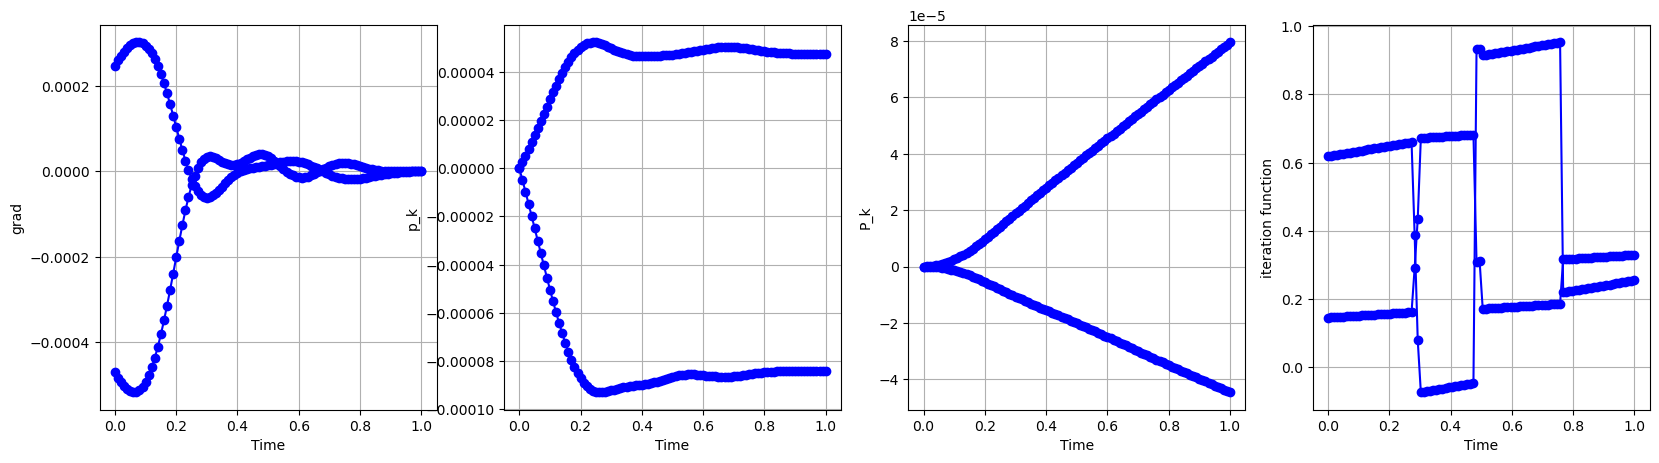

|p_max|/alpha:  106.6785759073994 , |P_max|/beta:  0.900827408777468
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.48869363 -0.87245547] x_0 = 0.26 , type = 0
weights:  [1.04291553e-06 2.88548778e-07 7.39791576e-07 1.47440080e-07
 2.61778713e-07 3.03184531e-07 9.11325553e-08] slope:  [0.05404481 0.15317176] y_shift [0.13762101 0.62773396]
Objective:  0.0001259372338093718
27 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.042915534007019e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8854877817150965e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.397915761373571e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4744007972187663e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.617787134954929e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 =

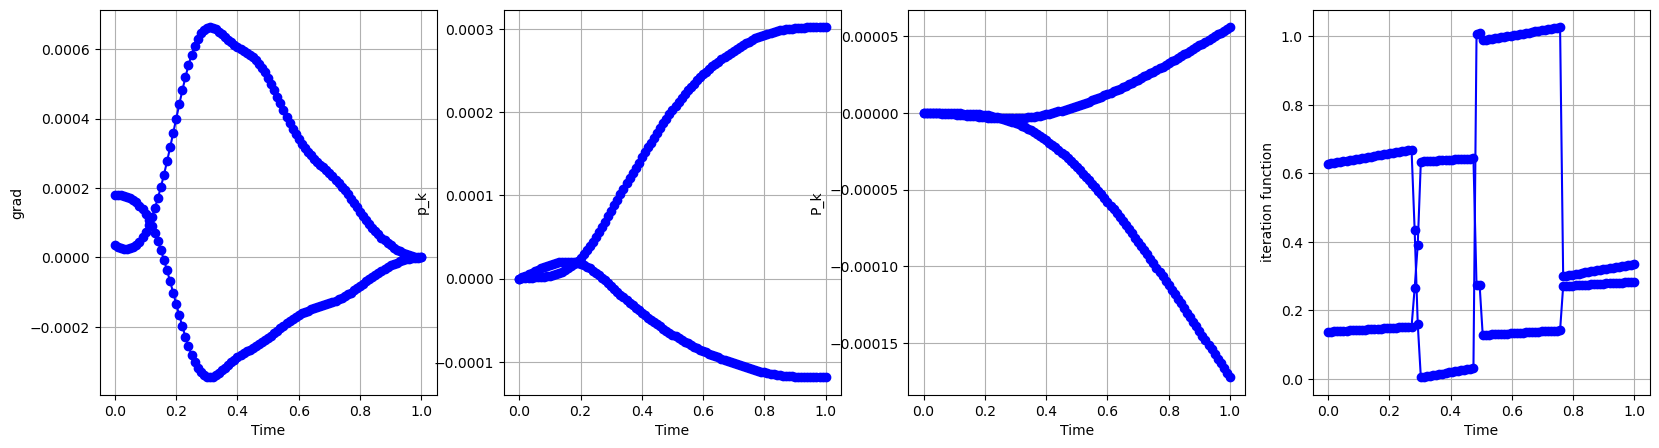

|p_max|/alpha:  324.8128342777763 , |P_max|/beta:  1.7812804480066844
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.36510108  0.93096788] x_0 = 0.99 , type = 0
weights:  [1.13132602e-06 2.82768985e-07 6.77847042e-07 1.33873280e-07
 6.99909672e-07 1.54596746e-07 0.00000000e+00] slope:  [0.05219338 0.14095562] y_shift [0.09285808 0.71288485]
Objective:  0.00010806567698303592
28 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1313260245622251e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.827689850964671e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778470418637455e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.33873280017064e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999096716256358e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 =

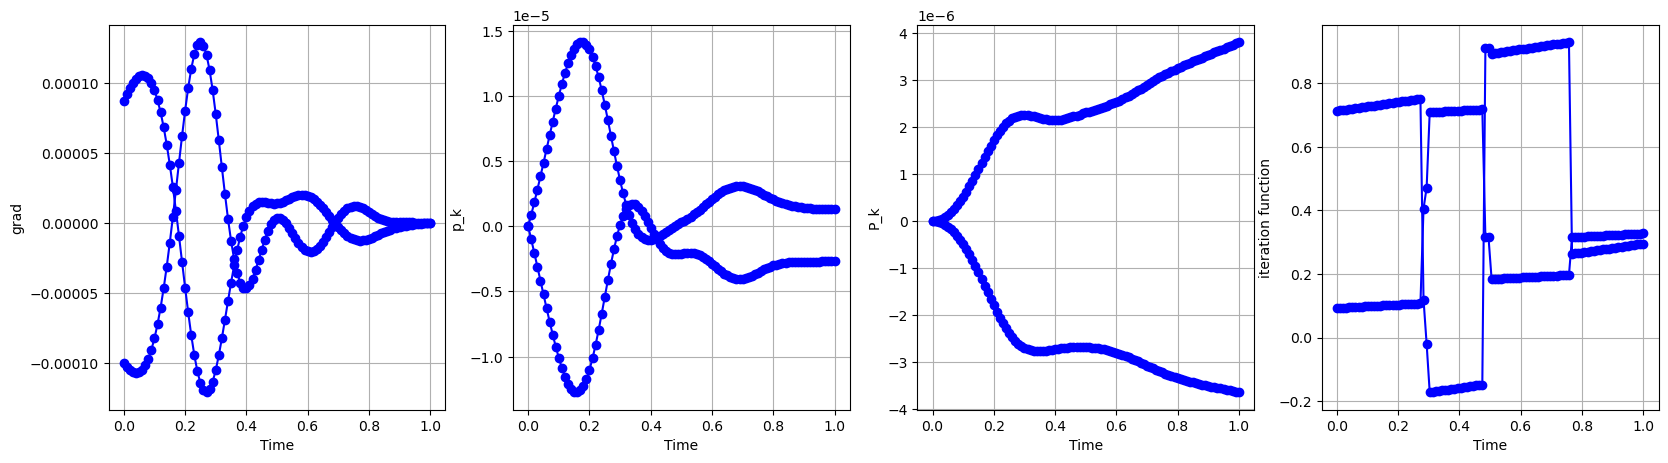

|p_max|/alpha:  18.917757837565663 , |P_max|/beta:  0.05234356887610715
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74647238 -0.6654164 ] x_0 = 0.17 , type = 0
weights:  [1.05833577e-06 2.99970946e-07 7.35032262e-07 1.48699545e-07
 3.05768394e-07 3.56405756e-07 1.64484105e-08] slope:  [0.05066634 0.15400551] y_shift [0.12906535 0.63730526]
Objective:  0.00011274977440574462
29 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0583357675453913e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.9997094616413873e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350322619852931e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4869954466579486e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.057683943202423e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	

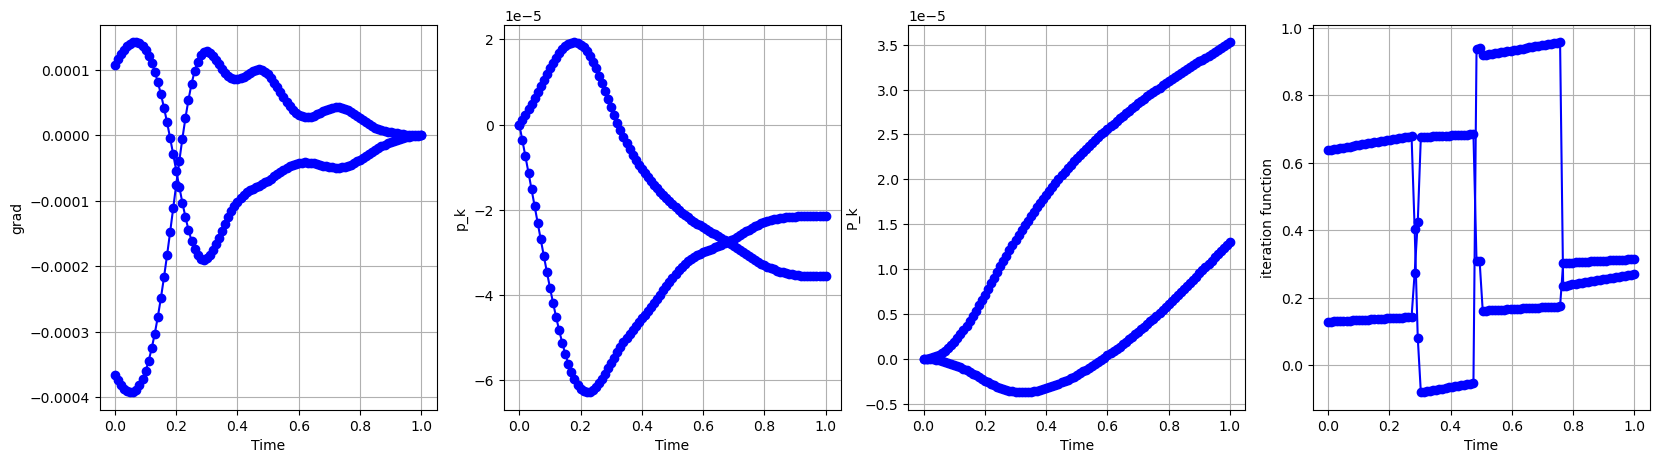

|p_max|/alpha:  65.1913461734458 , |P_max|/beta:  0.37301376451135887
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27794337 -0.96059746] x_0 = 0.21 , type = 0
weights:  [1.04634789e-06 2.81854388e-07 7.46681531e-07 1.41399046e-07
 3.02669793e-07 3.42365984e-07 2.59798580e-09] slope:  [0.05822593 0.15341425] y_shift [0.14588768 0.61866364]
Objective:  0.00011459708607619976
30 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0463478855448681e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.818543875231353e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.466815308606566e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4139904616230614e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.026697925994362e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

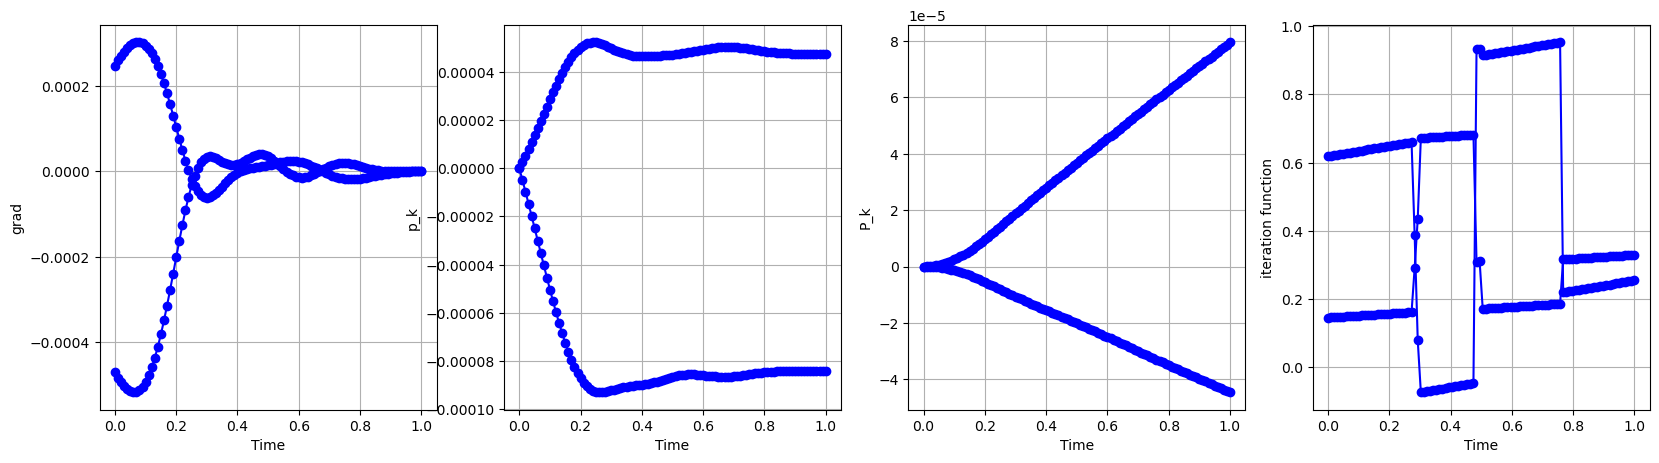

|p_max|/alpha:  106.67826692496989 , |P_max|/beta:  0.9008223955289641
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.48869475 -0.87245483] x_0 = 0.26 , type = 0
weights:  [1.04291562e-06 2.88548566e-07 7.39791549e-07 1.47440061e-07
 2.61778218e-07 3.03185379e-07 9.11325437e-08] slope:  [0.05404479 0.15317176] y_shift [0.13762097 0.62773401]
Objective:  0.00012593722291392583
31 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0429156239805804e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8854856593511814e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.397915485029172e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.474400613806573e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.617782179920134e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_

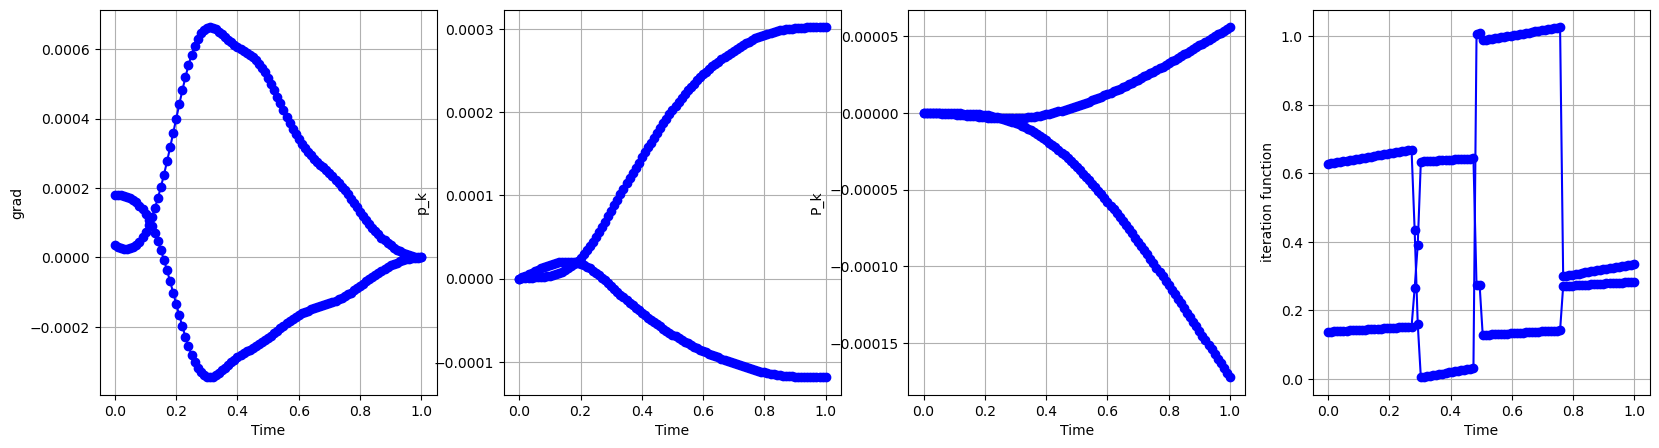

|p_max|/alpha:  324.8126742110822 , |P_max|/beta:  1.7812791379585506
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.36510323  0.93096704] x_0 = 0.99 , type = 0
weights:  [1.13132603e-06 2.82768991e-07 6.77847041e-07 1.33873277e-07
 6.99909673e-07 1.54596741e-07 0.00000000e+00] slope:  [0.05219337 0.14095561] y_shift [0.09285808 0.71288485]
Objective:  0.00010806567700167765
32 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1313260251126845e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.827689907207012e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778470413854158e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3387327668792953e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999096729904054e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

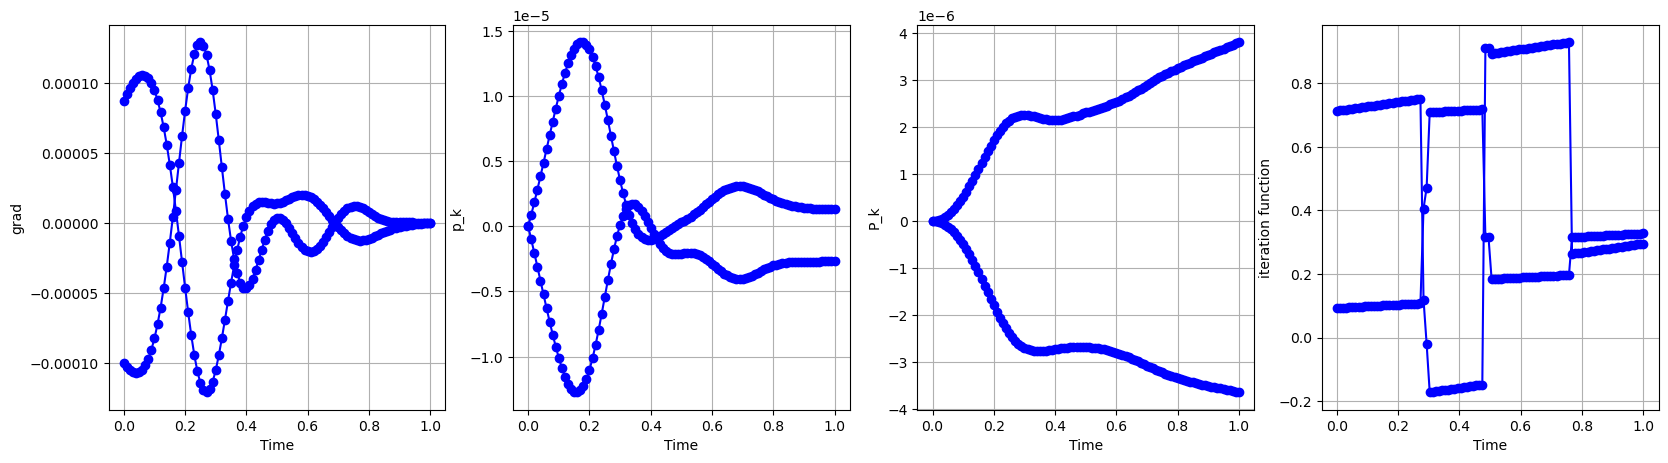

|p_max|/alpha:  18.91775786514395 , |P_max|/beta:  0.05234356850419937
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74647238 -0.6654164 ] x_0 = 0.17 , type = 0
weights:  [1.05833577e-06 2.99970946e-07 7.35032262e-07 1.48699545e-07
 3.05768395e-07 3.56405755e-07 1.64484104e-08] slope:  [0.05066634 0.15400551] y_shift [0.12906535 0.63730526]
Objective:  0.00011274977440788388
33 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0583357674609303e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.999709458286615e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350322620428409e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.486995446101572e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.0576839507548897e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_

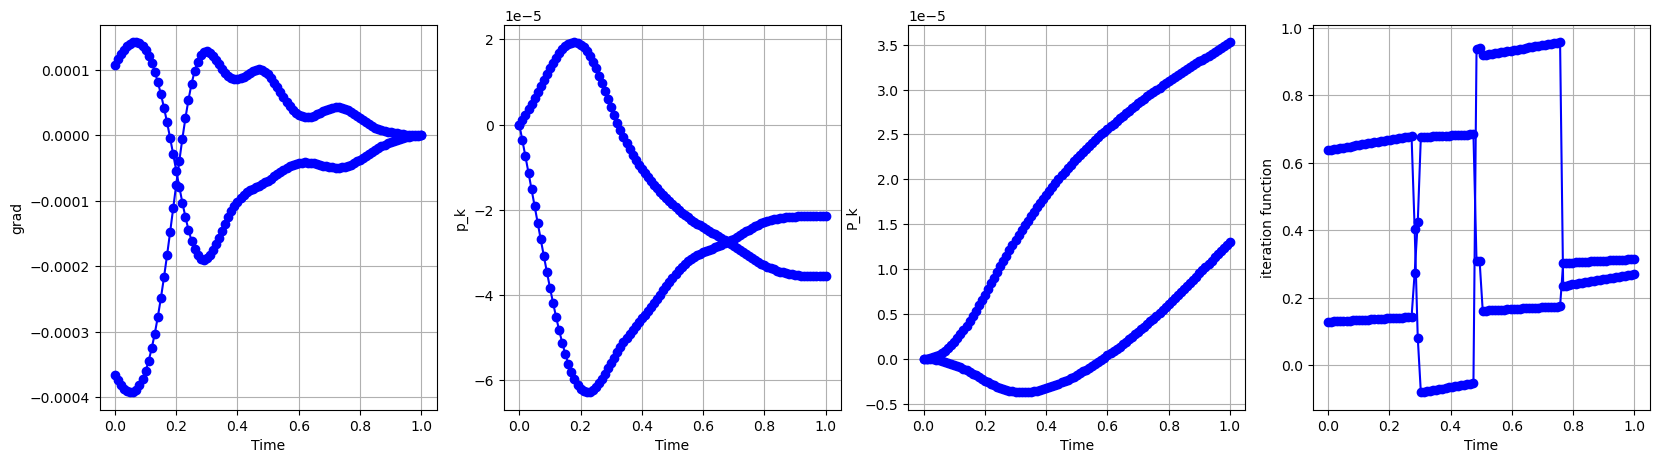

|p_max|/alpha:  65.19134658616245 , |P_max|/beta:  0.3730137733740178
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27794337 -0.96059746] x_0 = 0.21 , type = 0
weights:  [1.04634789e-06 2.81854387e-07 7.46681531e-07 1.41399046e-07
 3.02669795e-07 3.42365982e-07 2.59798529e-09] slope:  [0.05822593 0.15341425] y_shift [0.14588768 0.61866364]
Objective:  0.00011459708608709539
34 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0463478854774642e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8185438689582287e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.466815308831041e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4139904602328686e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.026697950423591e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_

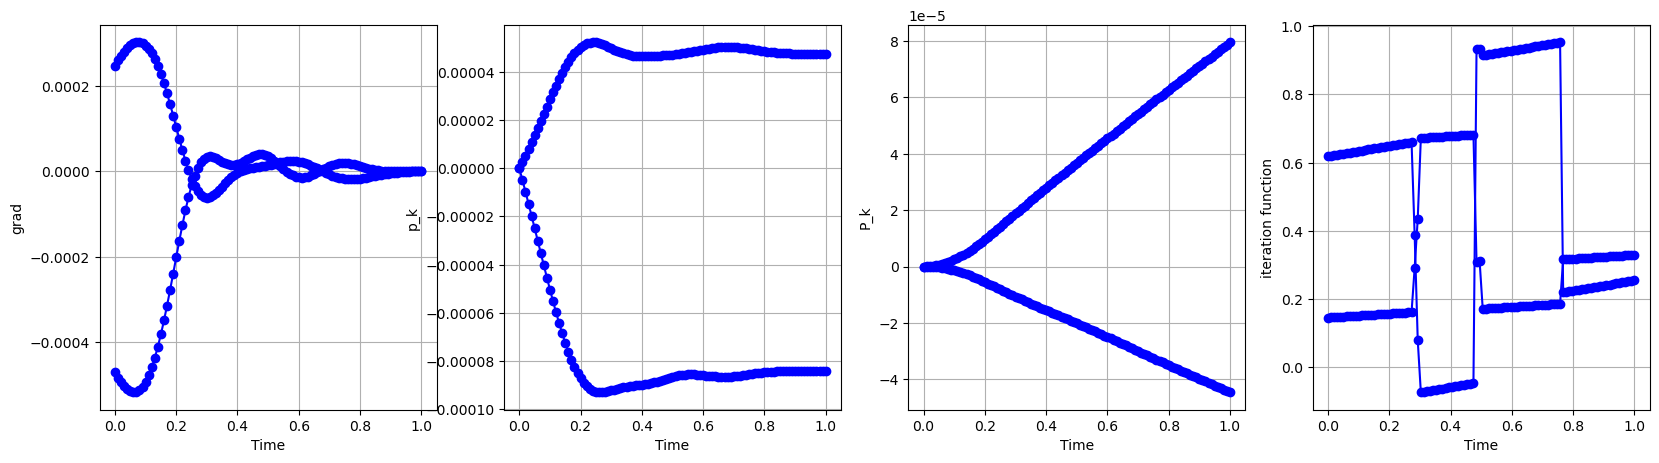

|p_max|/alpha:  106.67826807591486 , |P_max|/beta:  0.9008224142031233
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.48869475 -0.87245484] x_0 = 0.26 , type = 0
weights:  [1.04291562e-06 2.88548567e-07 7.39791549e-07 1.47440061e-07
 2.61778220e-07 3.03185376e-07 9.11325437e-08] slope:  [0.05404479 0.15317176] y_shift [0.13762097 0.62773401]
Objective:  0.00012593722295446325
35 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0429156236454501e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.885485667256988e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.397915486058554e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.474400614489691e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.617782198379517e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

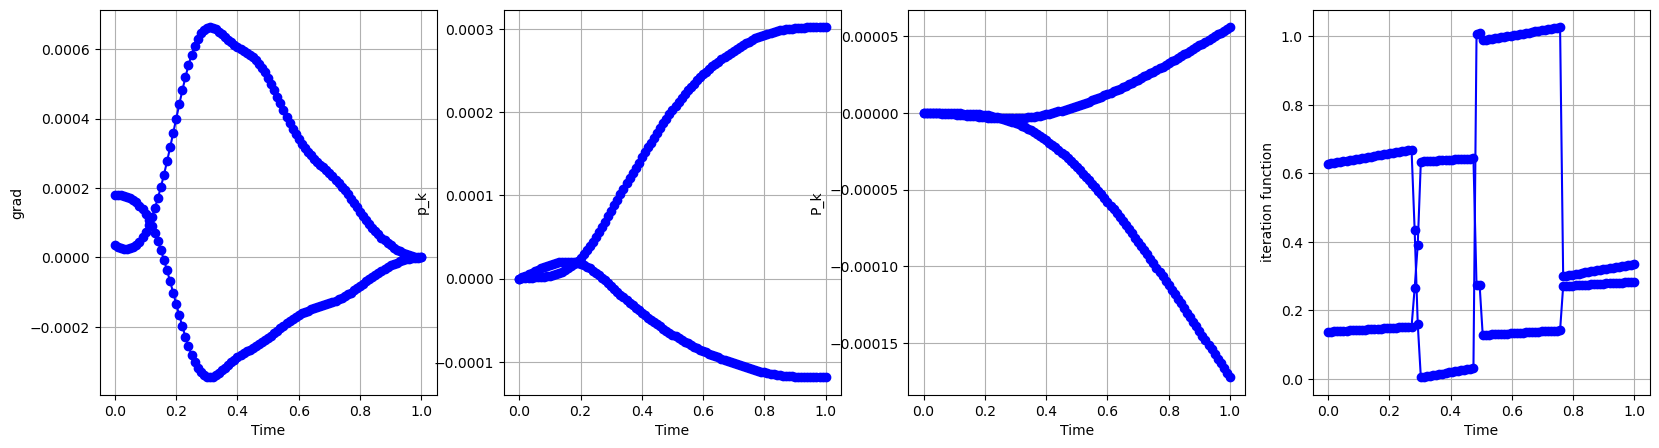

|p_max|/alpha:  324.81267480652184 , |P_max|/beta:  1.781279142833379
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.36510323  0.93096704] x_0 = 0.99 , type = 0
weights:  [1.13132603e-06 2.82768991e-07 6.77847041e-07 1.33873277e-07
 6.99909673e-07 1.54596741e-07 0.00000000e+00] slope:  [0.05219337 0.14095561] y_shift [0.09285808 0.71288485]
Objective:  0.00010806567700160724
36 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.131326025110595e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.82768990699822e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778470413871885e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3387327670035357e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999096729858264e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 =

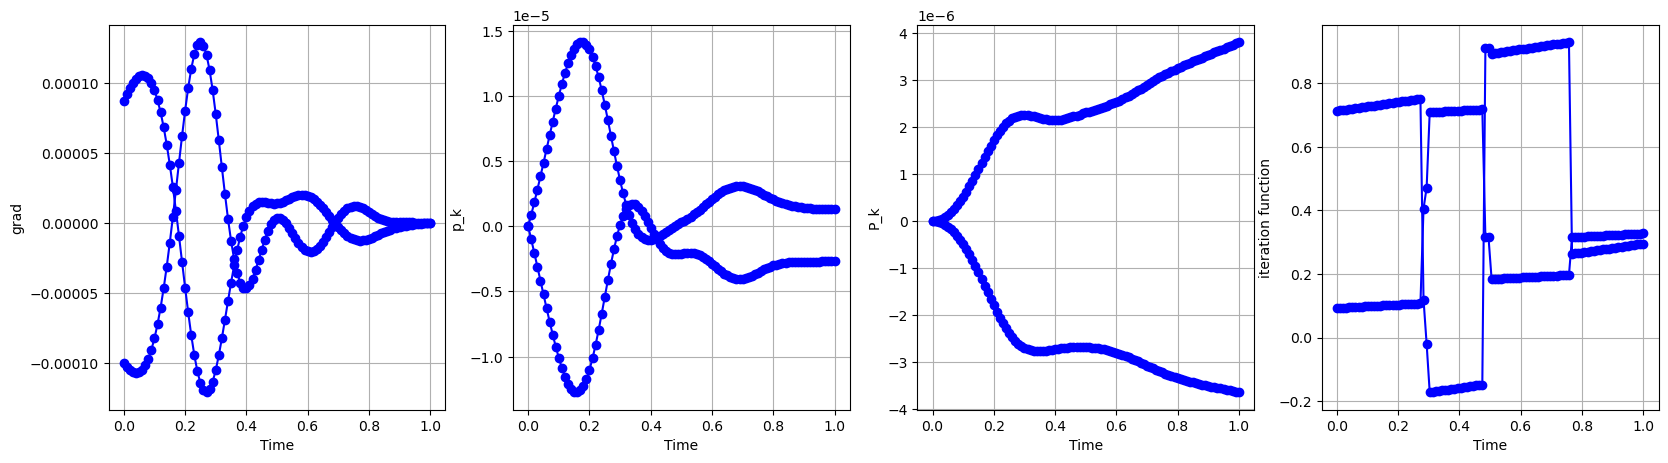

|p_max|/alpha:  18.917757865041438 , |P_max|/beta:  0.05234356850561324
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74647238 -0.6654164 ] x_0 = 0.17 , type = 0
weights:  [1.05833577e-06 2.99970946e-07 7.35032262e-07 1.48699545e-07
 3.05768395e-07 3.56405755e-07 1.64484104e-08] slope:  [0.05066634 0.15400551] y_shift [0.12906535 0.63730526]
Objective:  0.00011274977440787614
37 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0583357674612674e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.9997094582988783e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350322620426302e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4869954461034652e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.0576839507249455e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,

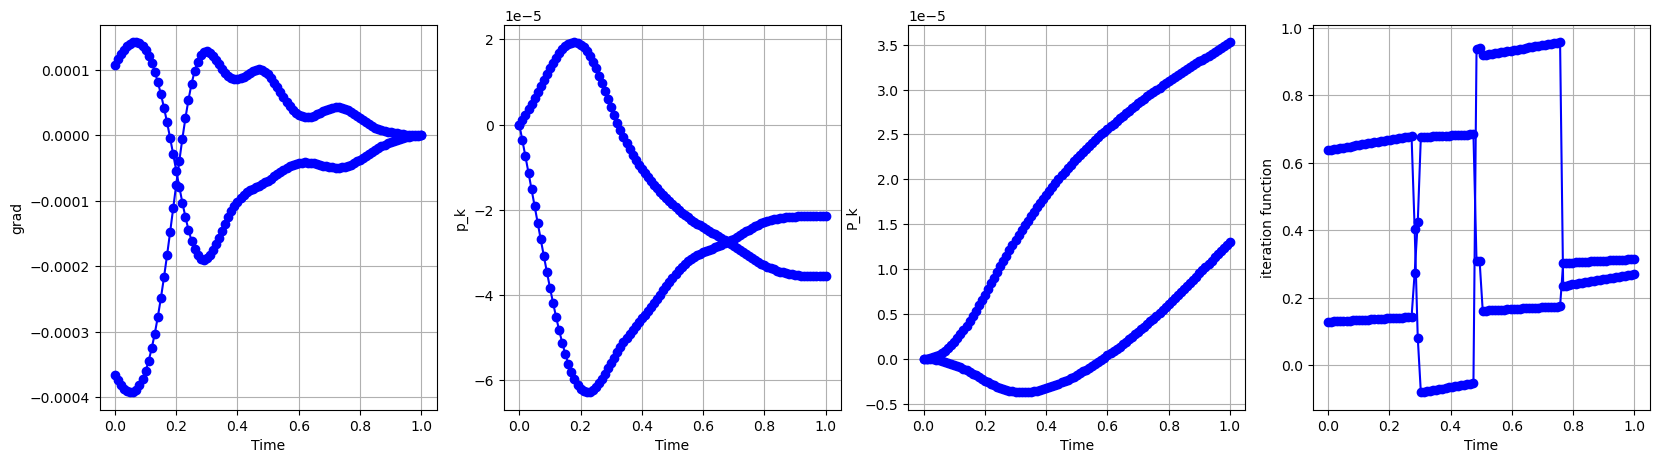

|p_max|/alpha:  65.19134658461009 , |P_max|/beta:  0.37301377334070124
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27794337 -0.96059746] x_0 = 0.21 , type = 0
weights:  [1.04634789e-06 2.81854387e-07 7.46681531e-07 1.41399046e-07
 3.02669795e-07 3.42365982e-07 2.59798529e-09] slope:  [0.05822593 0.15341425] y_shift [0.14588768 0.61866364]
Objective:  0.0001145970860870548
38 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0463478854777175e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8185438689817153e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.466815308830185e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4139904602380003e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.026697950330734e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_

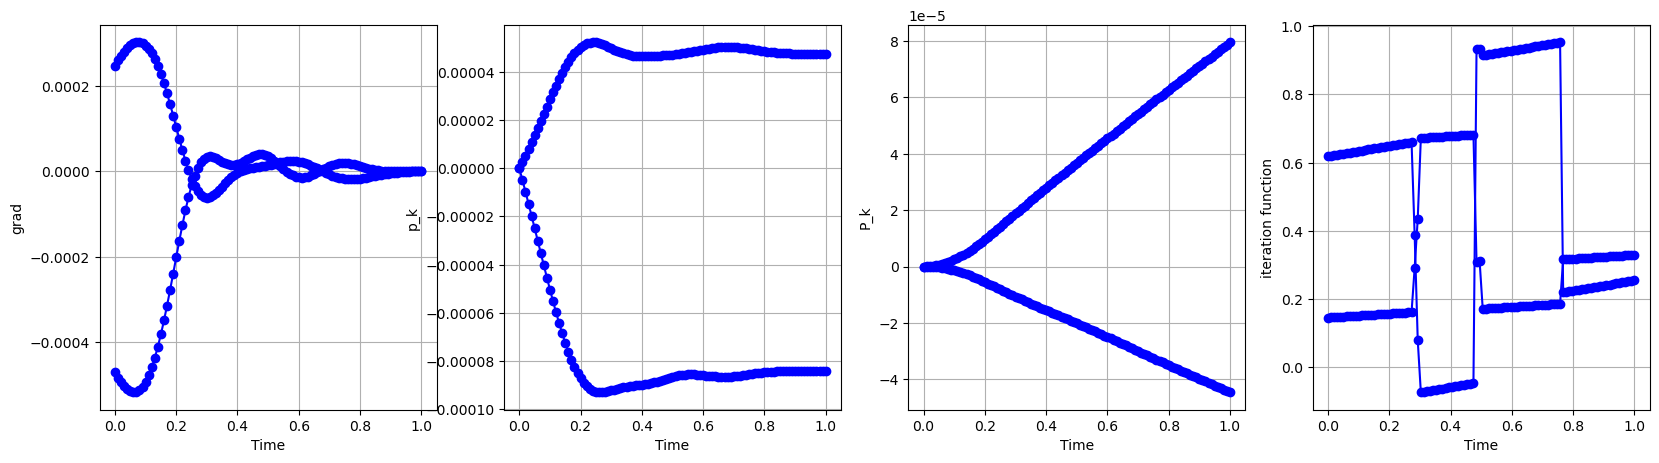

|p_max|/alpha:  106.67826807157738 , |P_max|/beta:  0.9008224141327211
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.48869475 -0.87245484] x_0 = 0.26 , type = 0
weights:  [1.04291562e-06 2.88548567e-07 7.39791549e-07 1.47440061e-07
 2.61778220e-07 3.03185376e-07 9.11325437e-08] slope:  [0.05404479 0.15317176] y_shift [0.13762097 0.62773401]
Objective:  0.0001259372229543494
39 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0429156236467038e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.885485667227092e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.397915486054717e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.474400614487179e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.617782198308029e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 

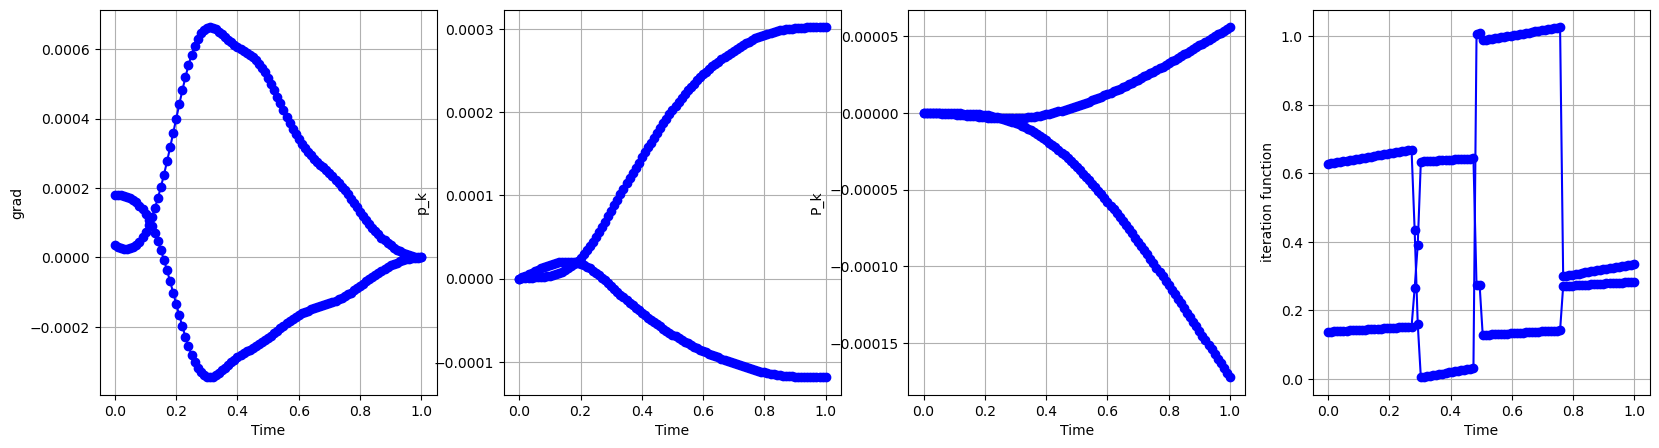

|p_max|/alpha:  324.8126748049283 , |P_max|/beta:  1.7812791428190864
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.36510323  0.93096704] x_0 = 0.99 , type = 0
weights:  [1.13132603e-06 2.82768991e-07 6.77847041e-07 1.33873277e-07
 6.99909673e-07 1.54596741e-07 0.00000000e+00] slope:  [0.05219337 0.14095561] y_shift [0.09285808 0.71288485]
Objective:  0.00010806567700160816
40 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.131326025110633e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8276899069988164e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778470413871875e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3387327670030505e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999096729854163e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

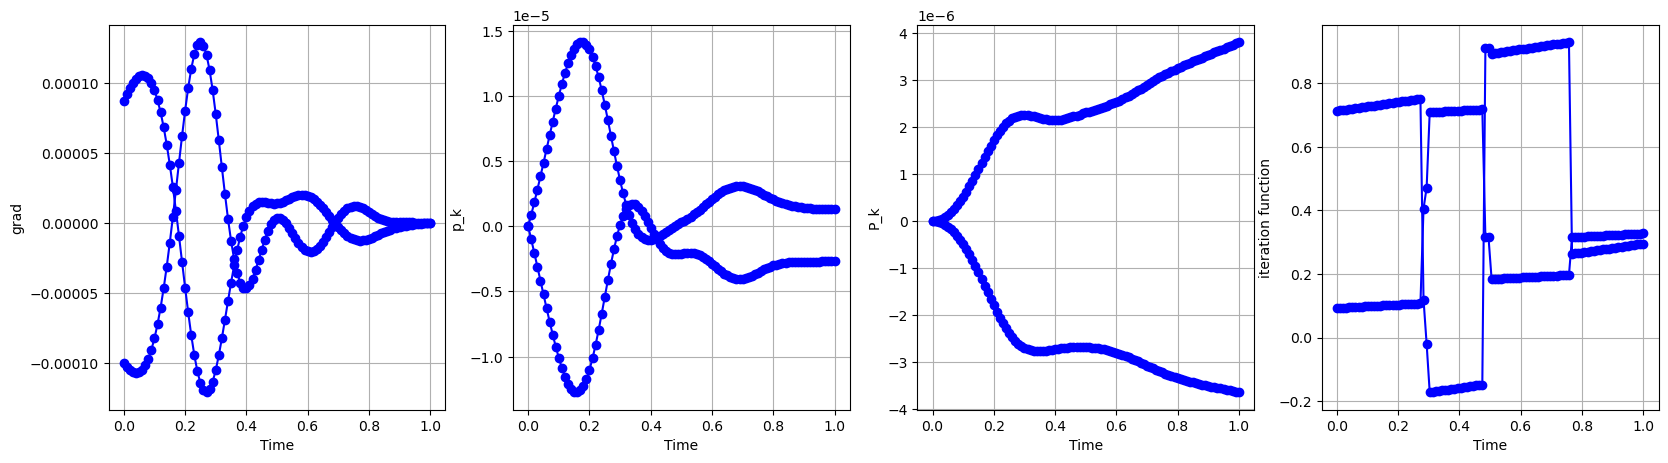

|p_max|/alpha:  18.91775786504129 , |P_max|/beta:  0.05234356850558311
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74647238 -0.6654164 ] x_0 = 0.17 , type = 0
weights:  [1.05833577e-06 2.99970946e-07 7.35032262e-07 1.48699545e-07
 3.05768395e-07 3.56405755e-07 1.64484104e-08] slope:  [0.05066634 0.15400551] y_shift [0.12906535 0.63730526]
Objective:  0.00011274977440787588
41 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.058335767461259e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.999709458298966e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350322620426232e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4869954461035737e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.057683950725873e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

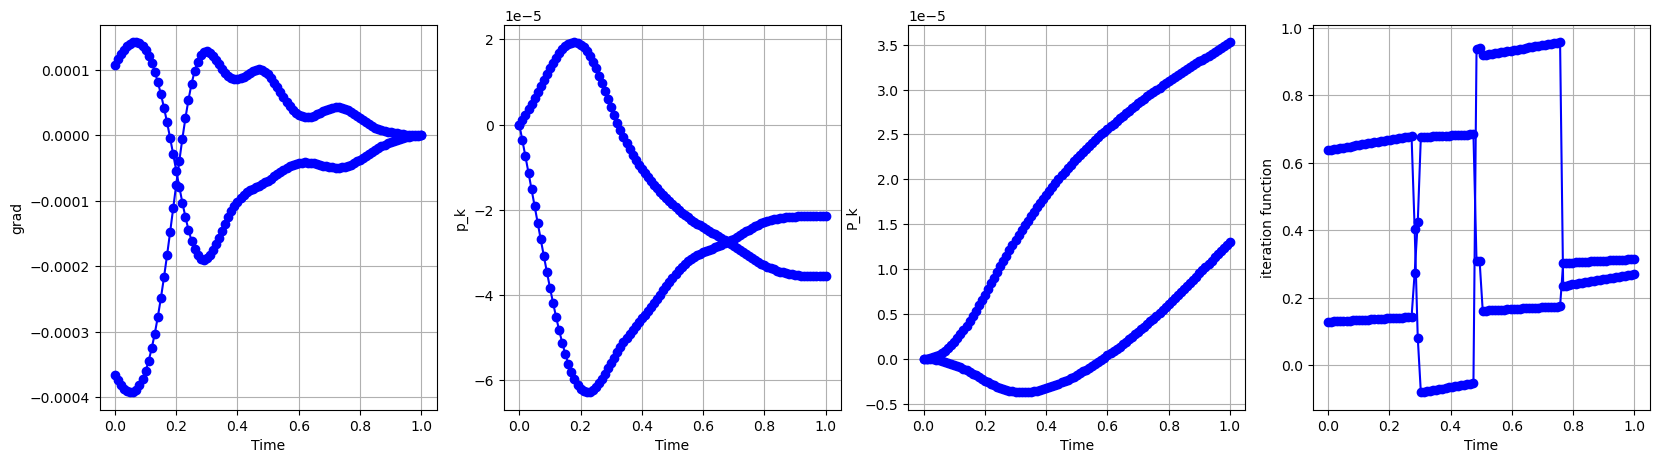

|p_max|/alpha:  65.19134658461678 , |P_max|/beta:  0.37301377334085944
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27794337 -0.96059746] x_0 = 0.21 , type = 0
weights:  [1.04634789e-06 2.81854387e-07 7.46681531e-07 1.41399046e-07
 3.02669795e-07 3.42365982e-07 2.59798529e-09] slope:  [0.05822593 0.15341425] y_shift [0.14588768 0.61866364]
Objective:  0.00011459708608705491
42 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0463478854777249e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8185438689814707e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.466815308830259e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4139904602378833e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.0266979503315747e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	

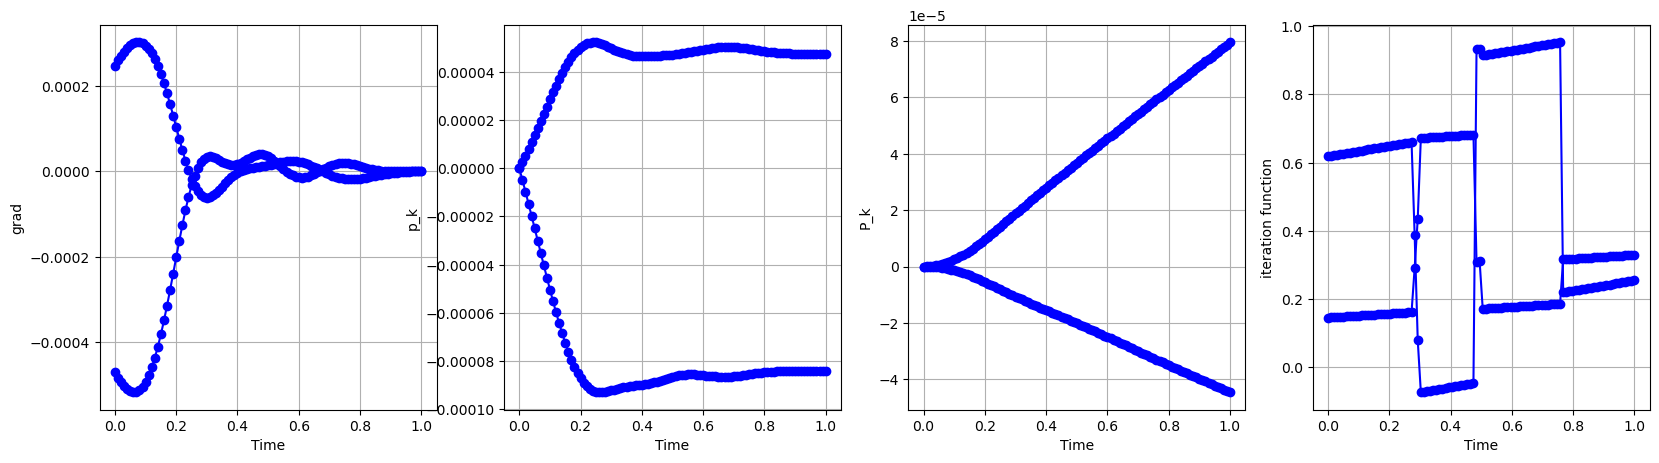

|p_max|/alpha:  106.6782680715977 , |P_max|/beta:  0.9008224141330502
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.48869475 -0.87245484] x_0 = 0.26 , type = 0
weights:  [1.04291562e-06 2.88548567e-07 7.39791549e-07 1.47440061e-07
 2.61778220e-07 3.03185376e-07 9.11325437e-08] slope:  [0.05404479 0.15317176] y_shift [0.13762097 0.62773401]
Objective:  0.00012593722295438814
43 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0429156236466838e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.885485667227028e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.397915486054707e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4744006144871447e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.617782198307294e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

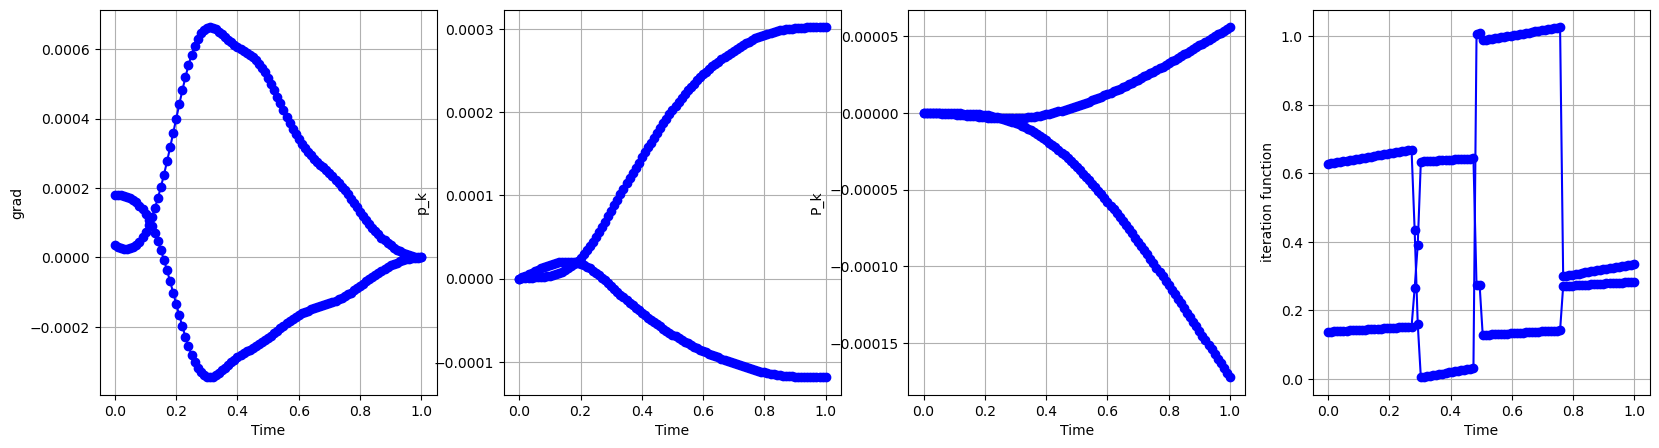

|p_max|/alpha:  324.81267480558955 , |P_max|/beta:  1.78127914282327
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.36510323  0.93096704] x_0 = 0.99 , type = 0
weights:  [1.13132603e-06 2.82768991e-07 6.77847041e-07 1.33873277e-07
 6.99909673e-07 1.54596741e-07 0.00000000e+00] slope:  [0.05219337 0.14095561] y_shift [0.09285808 0.71288485]
Objective:  0.00010806567700160799
44 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.1313260251106262e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.8276899069989033e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778470413871866e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3387327670031016e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999096729855631e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

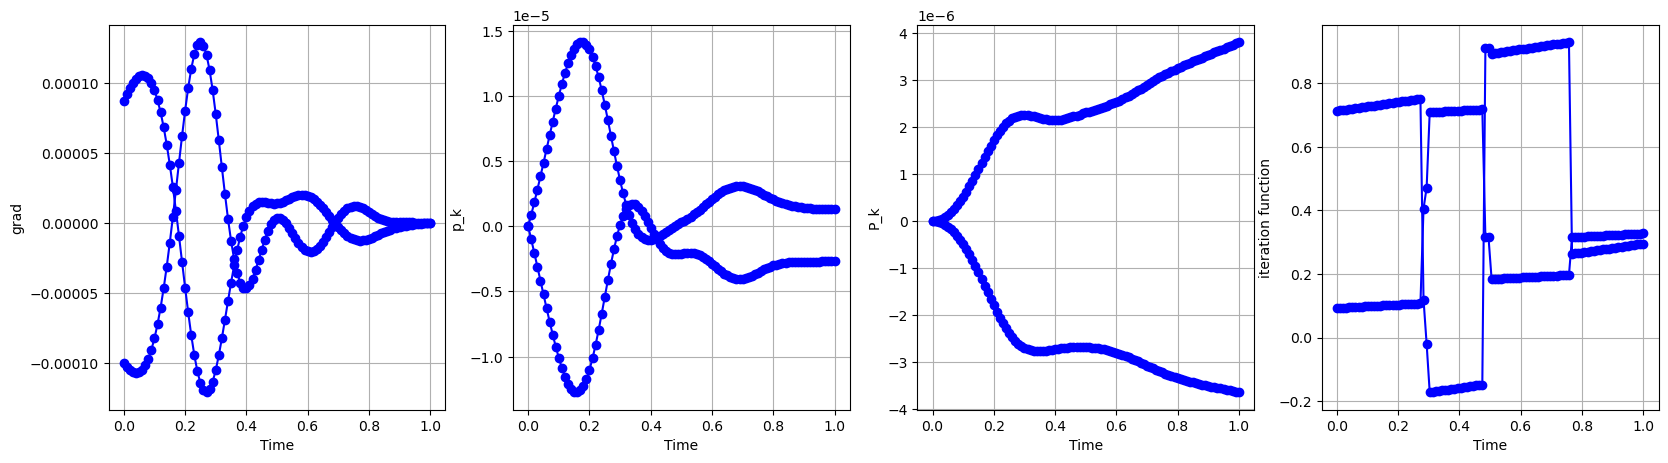

|p_max|/alpha:  18.917757865039462 , |P_max|/beta:  0.052343568505567734
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74647238 -0.6654164 ] x_0 = 0.17 , type = 0
weights:  [1.05833577e-06 2.99970946e-07 7.35032262e-07 1.48699545e-07
 3.05768395e-07 3.56405755e-07 1.64484104e-08] slope:  [0.05066634 0.15400551] y_shift [0.12906535 0.63730526]
Objective:  0.0001127497744078757
45 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0583357674612718e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.9997094582988105e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350322620426285e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4869954461034522e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.057683950725292e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	

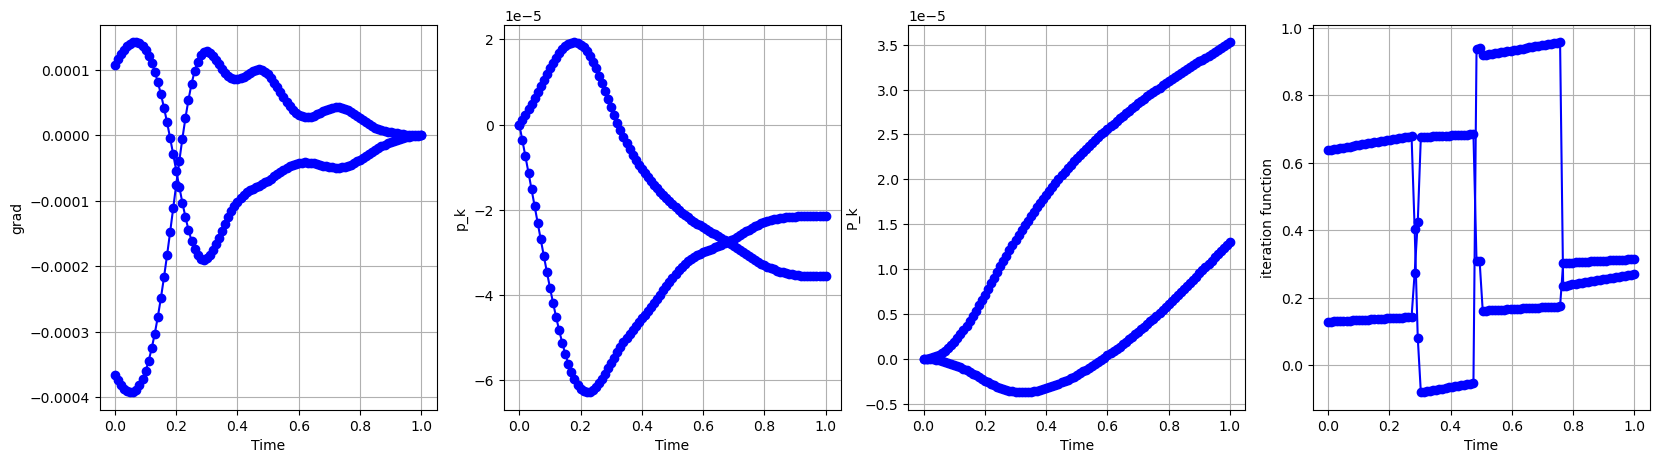

|p_max|/alpha:  65.19134658461786 , |P_max|/beta:  0.37301377334092223
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27794337 -0.96059746] x_0 = 0.21 , type = 0
weights:  [1.04634789e-06 2.81854387e-07 7.46681531e-07 1.41399046e-07
 3.02669795e-07 3.42365982e-07 2.59798529e-09] slope:  [0.05822593 0.15341425] y_shift [0.14588768 0.61866364]
Objective:  0.00011459708608705476
46 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0463478854777232e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.818543868981498e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.466815308830136e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4139904602379479e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.026697950331034e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_

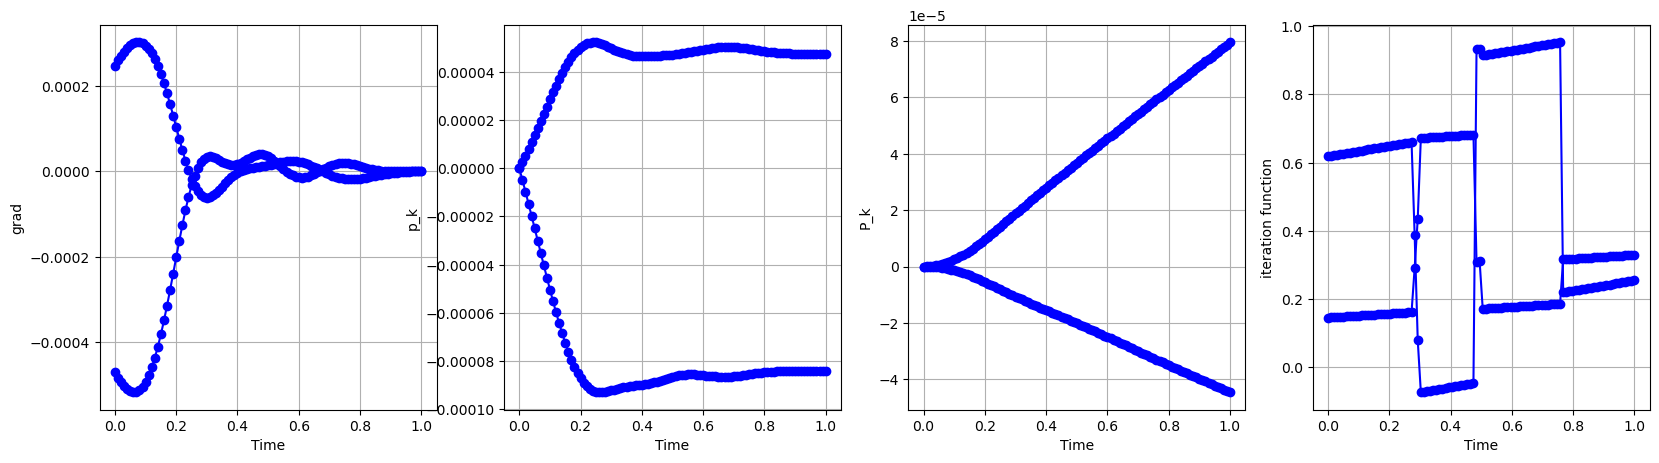

|p_max|/alpha:  106.67826807161393 , |P_max|/beta:  0.9008224141333498
x_S:  0.26 x_K:  0.99 
New point: sigma= [ 0.48869475 -0.87245484] x_0 = 0.26 , type = 0
weights:  [1.04291562e-06 2.88548567e-07 7.39791549e-07 1.47440061e-07
 2.61778220e-07 3.03185376e-07 9.11325437e-08] slope:  [0.05404479 0.15317176] y_shift [0.13762097 0.62773401]
Objective:  0.0001259372229543633
47 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0429156236466786e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.885485667227325e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.397915486054663e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4744006144872188e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 2.617782198308163e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0

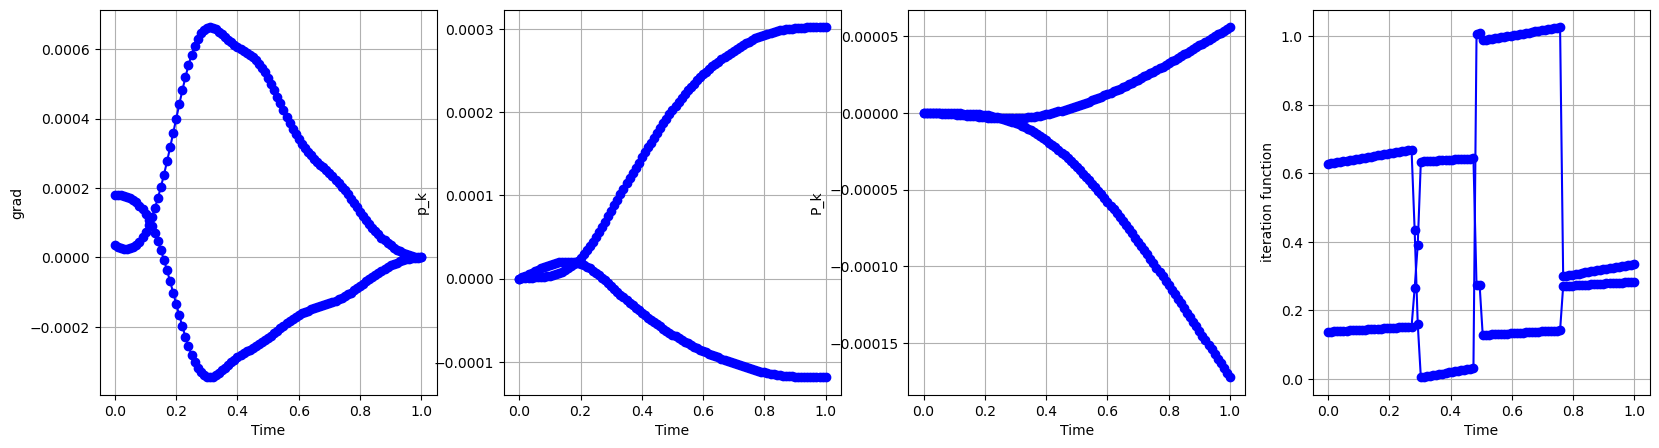

|p_max|/alpha:  324.8126748051676 , |P_max|/beta:  1.7812791428206418
x_S:  0.99 x_K:  0.99 
New point: sigma= [-0.36510323  0.93096704] x_0 = 0.99 , type = 0
weights:  [1.13132603e-06 2.82768991e-07 6.77847041e-07 1.33873277e-07
 6.99909673e-07 1.54596741e-07 0.00000000e+00] slope:  [0.05219337 0.14095561] y_shift [0.09285808 0.71288485]
Objective:  0.0001080656770016078
48 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.131326025110615e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.827689906998968e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 6.778470413871834e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.3387327670031296e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 6.999096729856764e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,	x_0 =

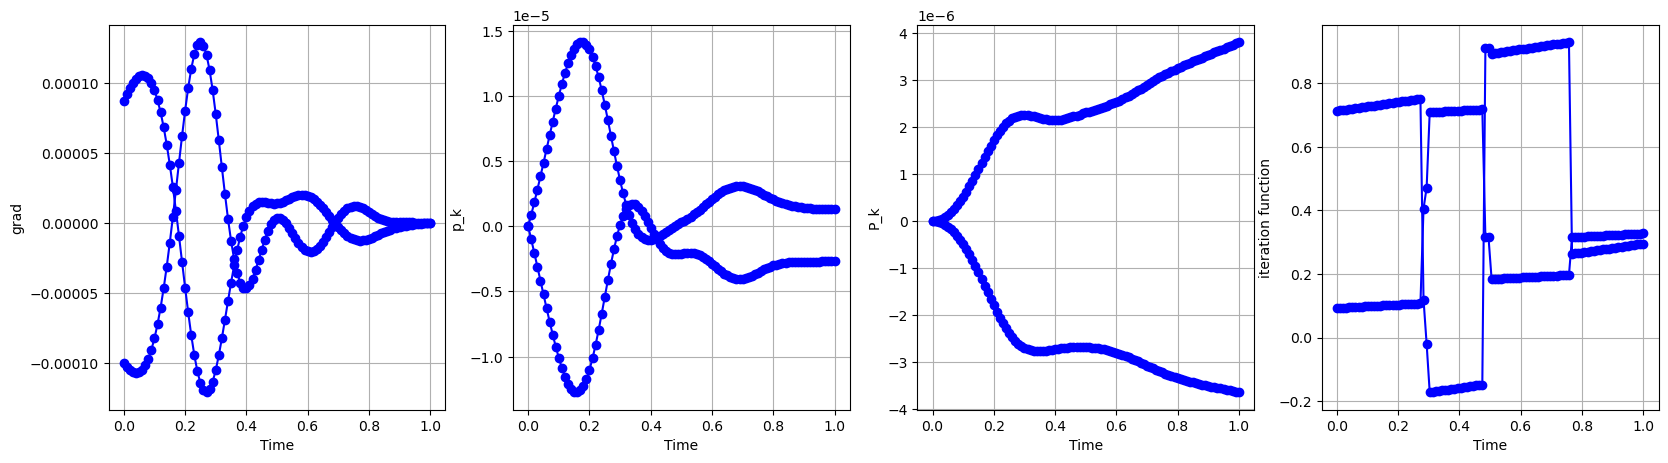

|p_max|/alpha:  18.917757865041434 , |P_max|/beta:  0.05234356850559751
x_S:  0.17 x_K:  0.99 
New point: sigma= [ 0.74647238 -0.6654164 ] x_0 = 0.17 , type = 0
weights:  [1.05833577e-06 2.99970946e-07 7.35032262e-07 1.48699545e-07
 3.05768395e-07 3.56405755e-07 1.64484104e-08] slope:  [0.05066634 0.15400551] y_shift [0.12906535 0.63730526]
Objective:  0.00011274977440787568
49 : Active set:
	 0 sigma= [-0.35643172  0.93432137] ,	x_0 = 0.48 ,	type = 0 	weight: 1.0583357674612602e-06 	id: 140627272111056
	 1 sigma= [ 0.83848577 -0.54492349] ,	x_0 = 0.3 ,	type = 0 	weight: 2.9997094582989423e-07 	id: 140627272335280
	 2 sigma= [ 0.17402233 -0.98474171] ,	x_0 = 0.76 ,	type = 0 	weight: 7.350322620426295e-07 	id: 140627272536368
	 3 sigma= [-0.98885747 -0.14886539] ,	x_0 = 0.5 ,	type = 0 	weight: 1.4869954461035298e-07 	id: 140627289922624
	 4 sigma= [ 0.4257493  -0.90484117] ,	x_0 = 0.28 ,	type = 0 	weight: 3.0576839507272293e-07 	id: 140627269654752
	 5 sigma= [ 0.41994472 -0.90754968] ,

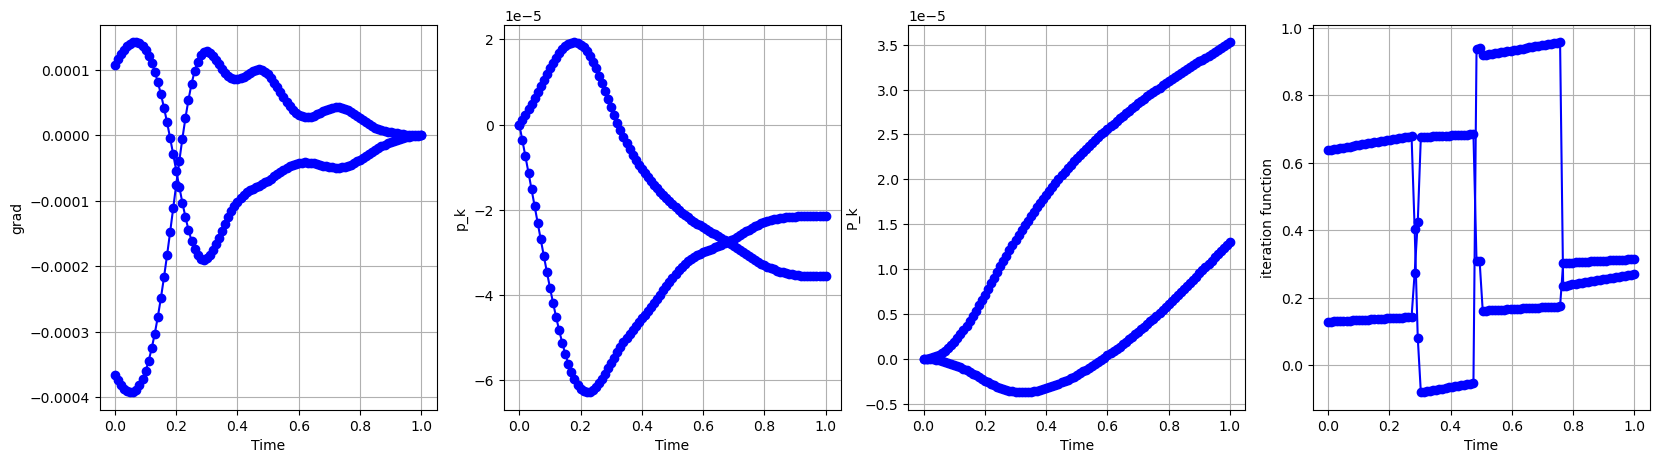

|p_max|/alpha:  65.1913465846151 , |P_max|/beta:  0.3730137733408162
x_S:  0.21 x_K:  0.99 
New point: sigma= [ 0.27794337 -0.96059746] x_0 = 0.21 , type = 0
weights:  [1.04634789e-06 2.81854387e-07 7.46681531e-07 1.41399046e-07
 3.02669795e-07 3.42365982e-07 2.59798529e-09] slope:  [0.05822593 0.15341425] y_shift [0.14588768 0.61866364]
Objective:  0.00011459708608705486


In [4]:
def algorithm(active_set: List[ExtremalPoint], weights: np.ndarray, slope: np.ndarray, y_shift: np.ndarray, params):
    hesse = HesseMatrix(active_set, params)
    constraintViolation = np.empty(params.maxIterations)
    constraintViolation[:] = np.nan
    print('Objective upper bound: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    weights, slope, y_shift = computeOSQPStep(weights, slope, y_shift, active_set, hesse, params)
    print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
    print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    for k in range(params.maxIterations):
        printIterationInfo(k, active_set, weights, slope, y_shift, hesse.matrix)
        u_k = lambda t: buildIterationFunction(t, active_set, weights, slope, y_shift, params)
        discreteDf = calculateDiscreteGradient(active_set, weights, slope, y_shift, hesse.standard_adjoints, params)
        p_k = integrateVectorFunction(discreteDf, params)
        P_k = -integrateVectorFunction(p_k, params)
        
        fig, (ax1, ax2, ax3, ax4) = mpl.pyplot.subplots(1, 4, figsize=(20, 5))
        plot_array(discreteDf, params.T, label='grad', ax=ax1)
        plot_array(p_k, params.T, label='p_k', ax=ax2)
        plot_array(P_k, params.T, label='P_k', ax=ax3)
        plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function', ax=ax4)
        mpl.pyplot.show()
        
        idx_S = getIdxMax(p_k, active_set, type=0)
        idx_K = getIdxMax(P_k, active_set, type=1)
        norm_p_max = np.linalg.norm(p_k[idx_S])
        norm_P_max = np.linalg.norm(P_k[idx_K])
        
        print('|p_max|/alpha: ', norm_p_max / params.alpha,  ', |P_max|/beta: ', norm_P_max / params.beta)
        constraintViolation[k] = max(norm_p_max / params.alpha, norm_P_max / params.beta) - 1
        if (max(norm_p_max / params.alpha, norm_P_max / params.beta) <= 1):
            break
        if norm_p_max / params.alpha >= norm_P_max / params.beta:
            active_set.append(ExtremalPoint(p_k[idx_S] / norm_p_max, idx_S * params.dt, type=0, params=params))
        else:
            active_set.append(ExtremalPoint(P_k[idx_K] / norm_P_max, idx_K * params.dt, type=1, params=params))

        print('x_S: ', idx_S * params.dt, 'x_K: ', idx_K * params.dt, '\nNew point: sigma=', active_set[-1].sigma, 'x_0 =', active_set[-1].x_0, ', type =', active_set[-1].type)
        hesse.extendMatrix(active_set[-1])
        weights, slope, y_shift = computeOSQPStep(np.concatenate((weights, np.array([0.]))), slope, y_shift, active_set, hesse, params)
        print('weights: ', weights, 'slope: ', slope, 'y_shift', y_shift)
        active_set, weights = pruneActiveSet(active_set, weights, params.pruneThreshold)
        hesse.pruneMatrix(active_set, weights)
        print('Objective: ', computeObjective(np.concatenate((weights, slope, y_shift)), active_set, hesse.standard_states, params))
    return weights, slope, y_shift, active_set, constraintViolation, u_k

active_set = []
weights = np.ones(len(active_set))
slope = np.ones(params.d)
y_shift = np.ones(params.d)
weights, slope, y_shift, active_set, constraintViolation, u_k = algorithm(active_set, weights, slope, y_shift, params)

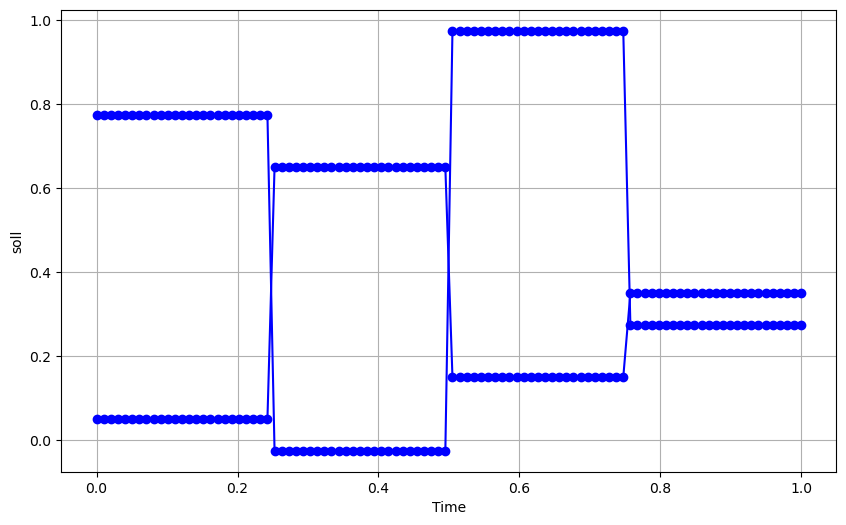

NameError: name 'u_k' is not defined

In [6]:
plot_array(array, params.T, label='soll')
plot_array(np.array([u_k(t) for t in discretInterval]), params.T, label='iteration function')
#plot_array(constraintViolation, params.maxIterations, label='violation')

mpl.pyplot.yscale('log')
mpl.pyplot.plot(constraintViolation)